# Lyft Bike Share Data Bay Area

Vsualizations of Lyft bike share usage in 2020. See [Sources](http://localhost:8888/notebooks/Desktop/Lyft%20Bike%20Project.ipynb#Sources) for details on data and processes.

### Research Question: How has behavior changed pre/post Covid?


### Things to Come Back to
* Ensuring no dupes across CSV files
* Getting data from website


#### Things Complete
* Start date as own variable, not overwritten
* Cleaning up April data in March file
* Cleaning up (0,0) rides
* Consolidating data clean up
* Re-indexing joined files
* Querying by condition (rides by day where covid=1, most popular station where member)
* Mapping points to city bounds
* Drop bad cells and update queries (NANs)
* Putting shape files somewhere publicly accessible
* Getting data April - forward

In [2]:
## Imports - General
import matplotlib.pyplot as plt
import numpy             as np
import matplotlib        as matplotlib
import pandas            as pd
from   datetime          import datetime

%matplotlib inline

## Imports - Plotting

import descartes
import geopandas as gpd
import glob
from shapely.geometry import Point, polygon

## Imports - Zip File
import os
import tarfile
from six.moves import urllib
import zipfile

In [135]:
## Download Zip Files, Unzip and Save

DOWNLOAD_ROOT = 'https://s3.amazonaws.com/baywheels-data/'
BW_PATH       = os.path.join('datasets', 'baywheelsdata')
BW_URL        = DOWNLOAD_ROOT +  '2017-fordgobike-tripdata.csv.zip'

In [145]:
def fetch_baywheels_data(bw_url = BW_URL,bw_path=BW_PATH):
    if not os.path.isdir(bw_path):
        os.makedirs(bw_path)
    for month in range(1):#,7):
        #file_name= '20200'+ str(month) + '-baywheels-tripdata.csv.zip'
        zip_path = os.path.join(bw_path,'2017-fordgobike-tripdata.csv.zip')        
        urllib.request.urlretrieve(bw_url,zip_path)
        baywheels_zip = tarfile.open(zip_path, mode='w')
        baywheels_zip.extractall(path = bw_path)
        baywheels_zip.close()

In [ ]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH  = os.path.join('datasets', 'housing')
HOUSING_URL   = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    #housing_tgz = tarfile.open(tgz_path)
    #housing_tgz.extractall(path = housing_path)
    
    housing_tgz.close()

In [56]:
## Reading in Q1 CSVs

df1 = pd.concat([pd.read_csv(f) for f in glob.glob('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/Q1/2020*-baywheels-tripdata.csv')], ignore_index=True)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [187]:
## Get April + June, because they have the same nice and easy columns, which we're renaming to match the Q1 data

cols=['ride_id','rideable_type','start_time','end_time','start_station_name','start_station_id','end_station_name','end_station_id','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude','rental_access_method']
df2 = pd.concat([pd.read_csv(f, header=0, names=cols) for f in \
glob.glob('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/Q2/AprJune/2020*-baywheels-tripdata.csv')]\
, ignore_index=True)

In [190]:
## May has an add'l 'is_equity' column that jacks everything up. Reading in separately because laziness

cols=['ride_id','rideable_type','start_time','end_time','start_station_name','start_station_id','end_station_name','end_station_id','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude','rental_access_method', 'is_equity']
df_may = pd.read_csv('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/Q2/202005-baywheels-tripdata.csv', header=0,names=cols)

In [191]:
df = pd.concat([df1,df2,df_may], join='inner')
df.head()

start_time                  end_time  start_station_id  \
0  2020-01-31 15:23:47.733000  2020-02-01 14:29:06.2630             400.0   
1  2020-01-31 15:40:31.616000  2020-02-01 10:37:51.0000              99.0   
2  2020-01-31 17:48:16.635000  2020-02-01 09:11:44.3170             197.0   
3  2020-01-31 17:53:03.413000  2020-02-01 09:08:32.6340             197.0   
4  2020-01-31 17:12:33.460000  2020-02-01 08:40:53.6460              12.0   

              start_station_name  start_station_latitude  \
0  Buchanan St at North Point St               37.804272   
1           Folsom St at 15th St               37.767037   
2    El Embarcadero at Grand Ave               37.808848   
3    El Embarcadero at Grand Ave               37.808848   
4    Pier 1/2 at The Embarcadero               37.796389   

   start_station_longitude  end_station_id               end_station_name  \
0              -122.433537           400.0  Buchanan St at North Point St   
1              -122.415443            99.0           Folsom St at 15th St   
2              -122.249680           197.0    El Embarcadero at Grand Ave   
3              -122.249680           197.0    El Embarcadero at Grand Ave   
4              -122.394586           371.0     Lombard St at Columbus Ave   

   end_station_latitude  end_station_longitude rental_access_method  
0             37.804272            -122.433537                  NaN  
1             37.767037            -122.415443                  NaN  
2             37.808848            -122.249680                  NaN  
3             37.808848            -122.249680                  NaN  
4             37.802746            -122.413579                  NaN

## Cleaning Up Data Set

* Small number (24 records, ~0.003% of total records) of records are from the `16th St Fleet Depot`. These records have a coordinate of (0,0) and it is not clear that these are legitimate rides. As such, I am updating them to `NaN` to ensure the proper display of the chart.
* Changing confusing nomenclature of users.
* Remove partial weeks at beginning/end of data set

In [210]:
## Identify number of records where starting coordinates = (0,0)

min_latitude = min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')

the min latitude is 37.2392
the max longitude is -121.77


In [193]:
## Updating (0,0) entries to Nan

df.loc[df['start_station_latitude'] == 0,'start_station_latitude'] = np.nan
df.loc[df['start_station_longitude'] == 0,'start_station_longitude'] = np.nan

In [194]:
## Rename 2 user types because it's very confusing that a 'customer' is a casual one-off purchaser!

df1.loc[df1['user_type'] == 'Subscriber','user_type'] = 'annual_subscriber'
df1.loc[df1['user_type'] == 'Customer','user_type'] = 'casual_rider'

In [195]:
## Confirming the above was done properly

min_latitude =  min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')

the min latitude is 37.2392
the max longitude is -121.77


In [197]:
## Populating basic date fields 

df["start_time"]  = pd.to_datetime(df["start_time"])
df1["start_time"]  = pd.to_datetime(df1["start_time"])
df["start_date"]  = df["start_time"].dt.date
df["start_month"] = df["start_time"].dt.month
df['start_week']  = df['start_time'].dt.weekofyear
df['first_day'] = df['start_time'] - df['start_time'].dt.weekday * np.timedelta64(1, 'D')
df['first_day'] = df['first_day'].dt.date

In [203]:
## Removing partial weeks

df = df.loc[df['start_time'] >= '01/06/20']
df = df.loc[df['start_time'] < '06/29/20']

In [204]:
## Make a Binary Pre-Post Covid Variable (Shelter in Place takes effect on 3/16)

df.loc[df['start_time'] >= '3/16/20', 'covid'] = 1
df.loc[df['start_time'] <  '3/16/20', 'covid'] = 0

### Adding the Shape Files
* Using zip for visualization
* Have some additional options below

In [27]:
#bay_area = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile/s7hs4j.shp')
#bay_area_counties = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile (1)/s7hs4j.shp')
#bay_area_cities = gpd.read_file('/Users/kailinkoch/Downloads/stanford-vj593xs7263-shapefile/vj593xs7263.shp')

In [205]:
bay_area_zips = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7888q-shapefile/s7888q.shp')

### Creating the GeoDataFrame

In [206]:
geometry = [Point(xy) for xy in zip(df["start_station_longitude"], df["start_station_latitude"])]

In [208]:
## Get all the data ready for the chart

geo_df = gpd.GeoDataFrame(df,
                          crs='EPSG:4326', ## CRS matches shape file (bay_area.crs)
                         geometry=geometry)

In [209]:
## Get the individual points mapped to their corresponding zip code

geo_df_with_zips = gpd.sjoin(geo_df, bay_area_zips, how='inner', op ='within')

In [211]:
## Just SF Data

geo_df_with_zips_sf = geo_df_with_zips.loc[geo_df_with_zips['PO_NAME']=='SAN FRANCISCO']

### Basic Information
- How have top stations changed pre/post Covid?
- How does rides by week changed pre/post Covid?

In [212]:
## How many rides in this data set? How many are pre-COVID?

total_rides = (geo_df_with_zips_sf['start_time'].count())
print(f'There are {total_rides} total rides in this data set')

precovid=geo_df_with_zips_sf.loc[geo_df_with_zips_sf['covid']==0]
postcovid=geo_df_with_zips_sf.loc[geo_df_with_zips_sf['covid']==1]

precovid_rides = precovid['start_time'].count()
print(f'There are {precovid_rides} rides from Pre-COVID in this data set')

There are 1022941 total rides in this data set
There are 705270 rides from Pre-COVID in this data set


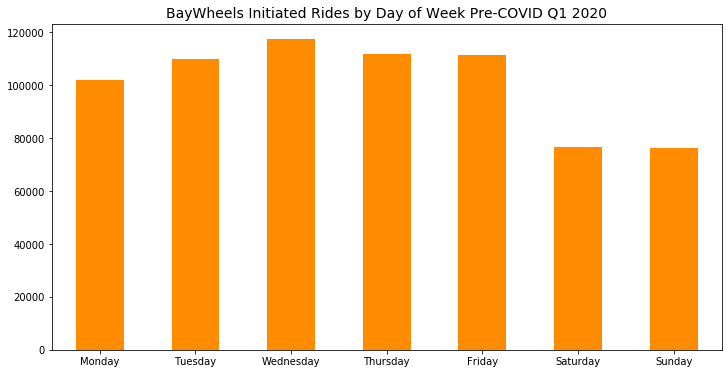

In [253]:
## Rides by Day of Week (PreCovid, 0 == Monday, 6 == Sunday)

dayofweek = precovid["start_time"].dt.weekday.value_counts().sort_index()

fig,ax = plt.subplots(figsize=(12,6))
dayofweek_figure = dayofweek.plot(kind = 'bar', color = 'darkorange')

plt.Axes.set_xticklabels(dayofweek_figure,labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation = 0)
plt.title('BayWheels Initiated Rides by Day of Week Pre-COVID Q1 2020', fontsize = 14, loc ='center')

## Same pattern for casual vs. annual
fig.savefig('baywheels_rides_by_dayofweek_precovid_q1_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

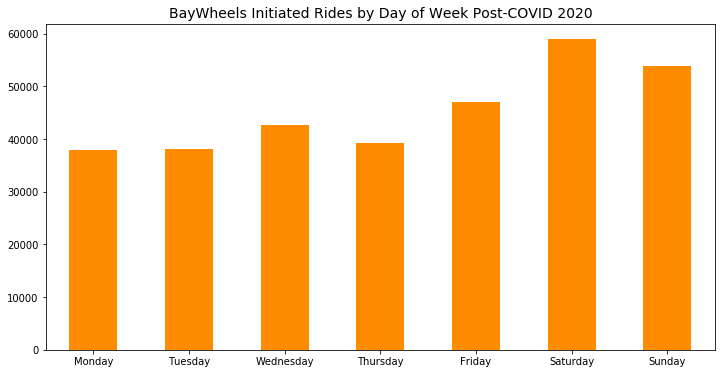

In [254]:
## Rides by Day of Week (PreCovid, 0 == Monday, 6 == Sunday)

dayofweek = postcovid["start_time"].dt.weekday.value_counts().sort_index()

fig,ax = plt.subplots(figsize=(12,6))
dayofweek_figure = dayofweek.plot(kind = 'bar', color = 'darkorange')

plt.Axes.set_xticklabels(dayofweek_figure,labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation = 0)
plt.title('BayWheels Initiated Rides by Day of Week Post-COVID 2020', fontsize = 14, loc ='center')

## Same pattern for casual vs. annual
fig.savefig('baywheels_rides_by_dayofweek_postcovid_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

In [221]:
## Most Popular Stations PreCovid

top_stations_precovid=pd.DataFrame(precovid.groupby(["start_station_name"],as_index=False).size().sort_values(ascending=False).head(10))
top_stations_precovid.reset_index(inplace=True)
top_stations_precovid.rename({0:'number_of_rides'}, axis='columns', inplace=True)
top_stations_precovid

start_station_name  number_of_rides
0                               Market St at 10th St             7013
1     San Francisco Caltrain (Townsend St at 4th St)             6968
2                                 Berry St at 4th St             6070
3                              Howard St at Beale St             5046
4                            Market St at Steuart St             4717
5       Powell St BART Station (Market St at 4th St)             4446
6  San Francisco Ferry Building (Harry Bridges Pl...             4382
7       Powell St BART Station (Market St at 5th St)             4280
8   Montgomery St BART Station (Market St at 2nd St)             4154
9                         Rhode Island St at 17th St             3138

In [220]:
# 10 Most Popular Stations Post Covid

top_stations_covid=pd.DataFrame(postcovid.groupby(["start_station_name"],as_index=False).size().sort_values(ascending=False).head(10))
top_stations_covid.reset_index(inplace=True)
top_stations_covid.rename({0:'number_of_rides'}, axis='columns', inplace=True)
top_stations_covid

start_station_name  number_of_rides
0                          Market St at 10th St             3922
1                         Fell St at Stanyan St             3154
2                            Hyde St at Post St             2932
3  Powell St BART Station (Market St at 4th St)             2572
4                          Mission Dolores Park             2417
5                             4th St at 16th St             2189
6                       Market St at Dolores St             2154
7                        Broderick St at Oak St             2141
8                       48th Ave at Cabrillo St             2113
9                       Market St at Steuart St             2090

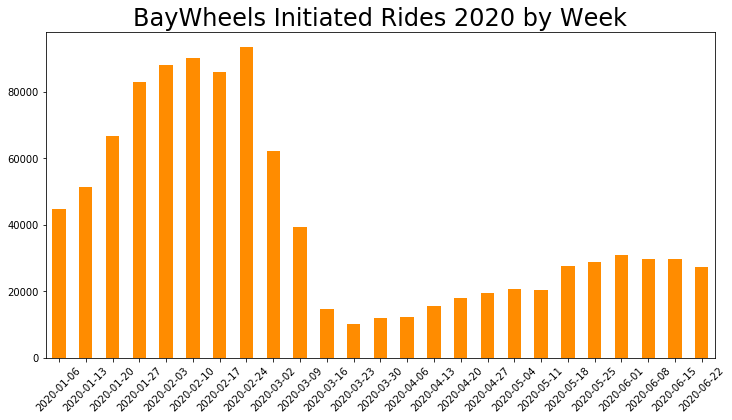

In [231]:
# 2020 Rides by Week

rides_by_week=geo_df_with_zips_sf['first_day'].value_counts().sort_index()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_week_figure=rides_by_week.plot(ax=ax, kind='bar', color='darkorange')
plt.title('BayWheels Initiated Rides 2020 by Week', fontsize=24, loc='center')
plt.xticks(rotation=45)

fig.savefig('baywheels_rides_by_week_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')
        

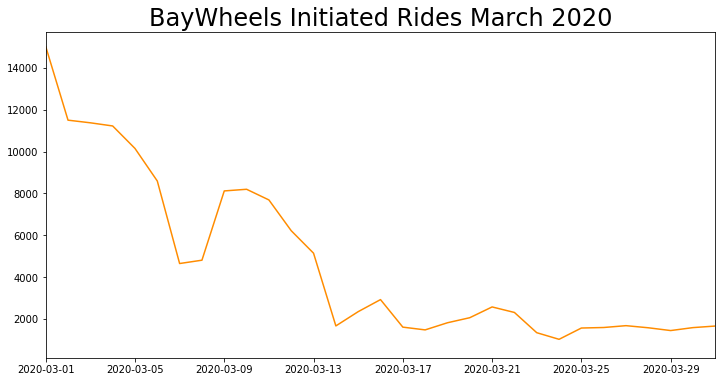

In [232]:
## Rides by day in March?
rides_by_day=geo_df_with_zips_sf['start_date'].value_counts().sort_index()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_day.plot(ax=ax,kind='line', xlim= ['3/1/20', '3/31/20'], color='darkorange')
plt.title('BayWheels Initiated Rides March 2020', fontsize=24, loc='center')

fig.savefig('baywheels_rides_by_day_march_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

In [244]:
index = geo_df_with_zips_sf.index

In [247]:
## Gets counts by week by zip
dfpivot = pd.pivot_table(geo_df_with_zips_sf,index=['ZIP', 'first_day'],values='start_date',aggfunc={'start_date':'count'})
dfpivot.reset_index(inplace=True)
dfpivot.rename({"start_date": "count"}, axis='columns', inplace=True)
dfpivot.head()

ZIP   first_day  count
0  94102  2020-01-06   3097
1  94102  2020-01-13   3593
2  94102  2020-01-20   4743
3  94102  2020-01-27   5822
4  94102  2020-02-03   6136

In [249]:
## Merge the counts back in with the geometric data

geo_df_with_counts = bay_area_zips.merge(dfpivot, how='inner',on='ZIP')
geo_df_with_counts

ZIP        PO_NAME STATE        Area__      Length__  \
0    94133  SAN FRANCISCO    CA  2.155245e+07  43114.362360   
1    94133  SAN FRANCISCO    CA  2.155245e+07  43114.362360   
2    94133  SAN FRANCISCO    CA  2.155245e+07  43114.362360   
3    94133  SAN FRANCISCO    CA  2.155245e+07  43114.362360   
4    94133  SAN FRANCISCO    CA  2.155245e+07  43114.362360   
..     ...            ...   ...           ...           ...   
617  94134  SAN FRANCISCO    CA  6.751601e+07  44866.521548   
618  94134  SAN FRANCISCO    CA  6.751601e+07  44866.521548   
619  94134  SAN FRANCISCO    CA  6.751601e+07  44866.521548   
620  94134  SAN FRANCISCO    CA  6.751601e+07  44866.521548   
621  94134  SAN FRANCISCO    CA  6.751601e+07  44866.521548   

                                              geometry   first_day  count  
0    MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-06    999  
1    MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-13   1372  
2    MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-20   2069  
3    MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-27   2489  
4    MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-02-03   2650  
..                                                 ...         ...    ...  
617  POLYGON ((-122.42066 37.73204, -122.41521 37.7...  2020-05-25     44  
618  POLYGON ((-122.42066 37.73204, -122.41521 37.7...  2020-06-01     58  
619  POLYGON ((-122.42066 37.73204, -122.41521 37.7...  2020-06-08     53  
620  POLYGON ((-122.42066 37.73204, -122.41521 37.7...  2020-06-15     59  
621  POLYGON ((-122.42066 37.73204, -122.41521 37.7...  2020-06-22     38  

[622 rows x 8 columns]

### Creating Final Visualization

In [250]:
## Function to print the graphs for the final GIF
plt.ioff()

def print_map(x):
    range = x['count']
    norm=matplotlib.colors.Normalize(vmin=range.min(), vmax=range.max())
    for week in x['first_day']:
        geo_df_with_counts_day = x.loc[x['first_day']==week]
        fig,ax=plt.subplots(figsize=(15,15))
        #ax.set(xlim=[-122.75,-121.55], ylim=[37.7,38.0], aspect=1)
        ax.set(xlim=[-122.6,-122.3], ylim=[37.685,37.82], aspect=1)
        bay_area_zips.plot(ax = ax, figsize=(15,15), alpha=0.4, color='lightgrey')
        geo_df_with_counts_day.plot(ax = ax, column='count', norm=norm, cmap='Oranges')
        plt.title('BayWheels Rides Week of '+str(week), fontsize=24, loc='center')
        sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
        sm.set_array([])
        plt.colorbar(sm,ax=ax, norm=norm,cmap='Oranges', shrink=0.48)
        fig.savefig(str(week)+'_baywheels_bywk_byzip'+ '.png', facecolor='white', dpi=150, bbox_inches='tight')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

KeyboardInterrupt: 

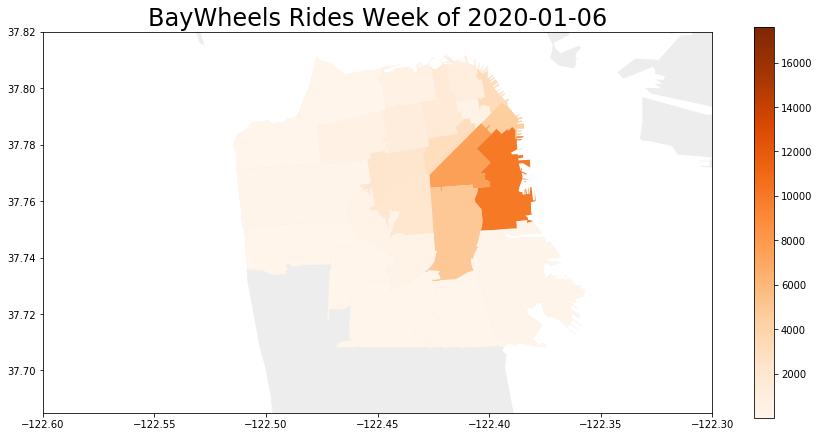

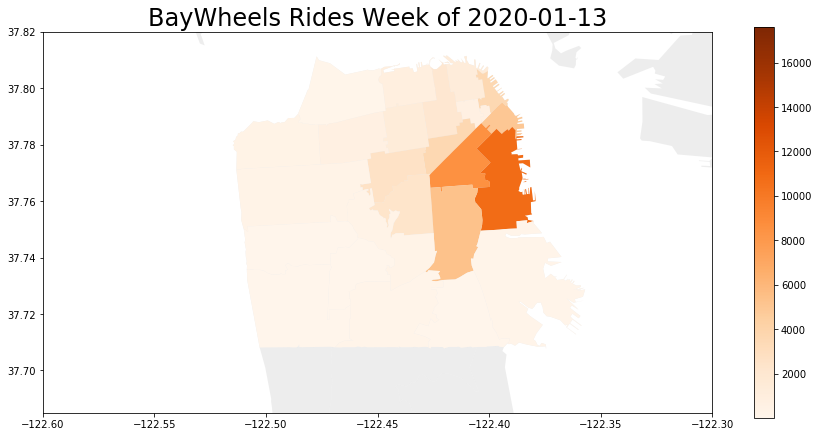

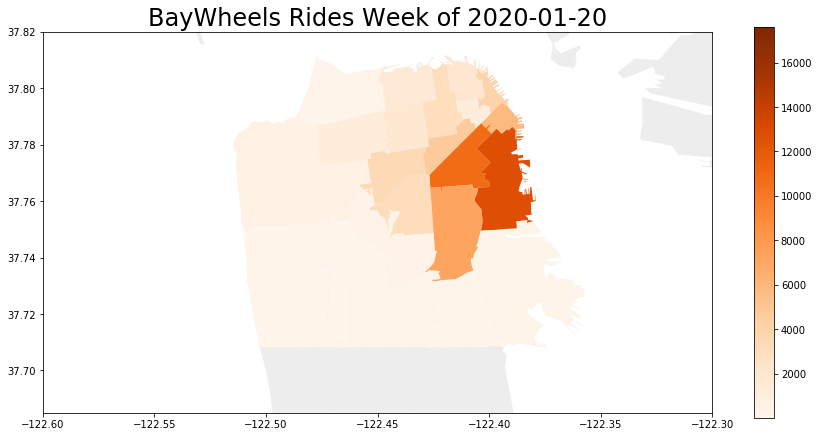

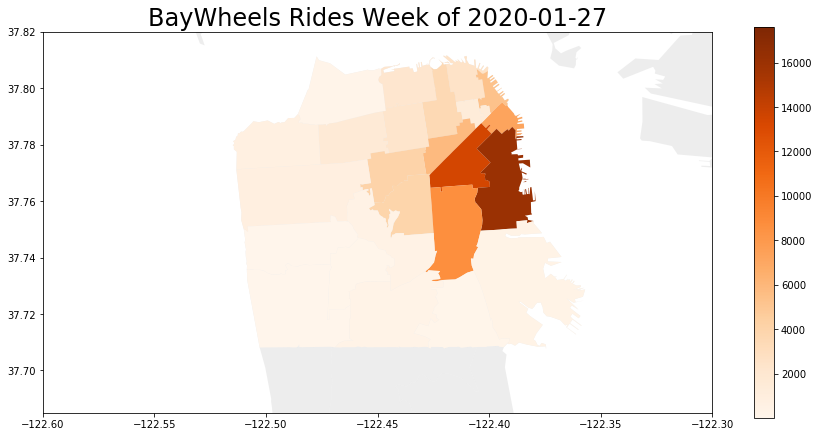

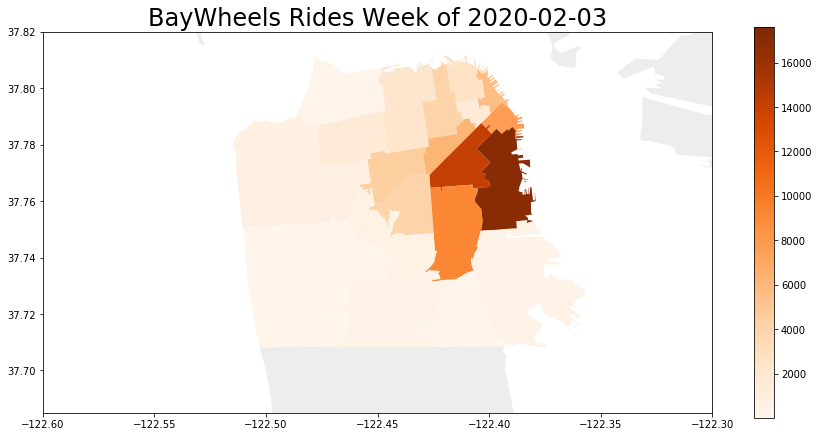

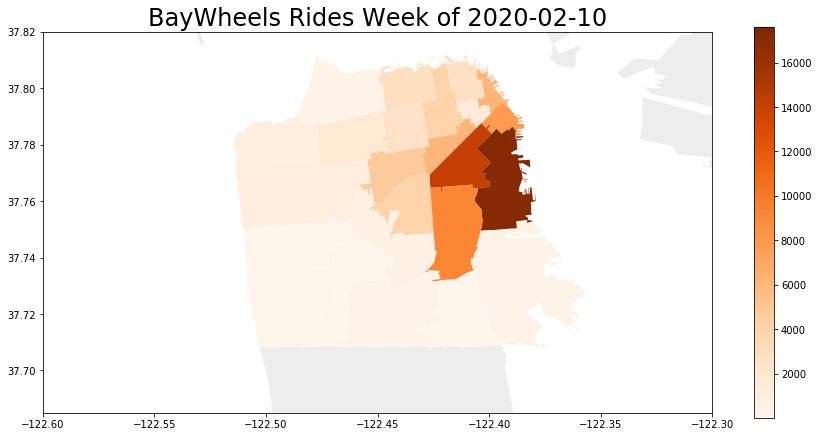

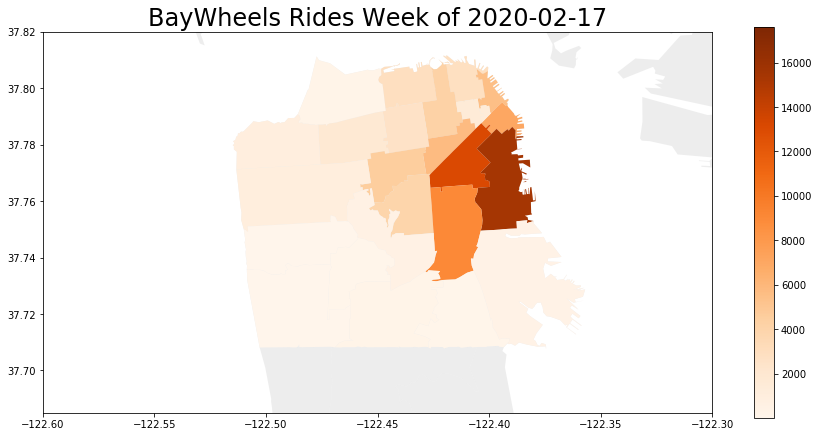

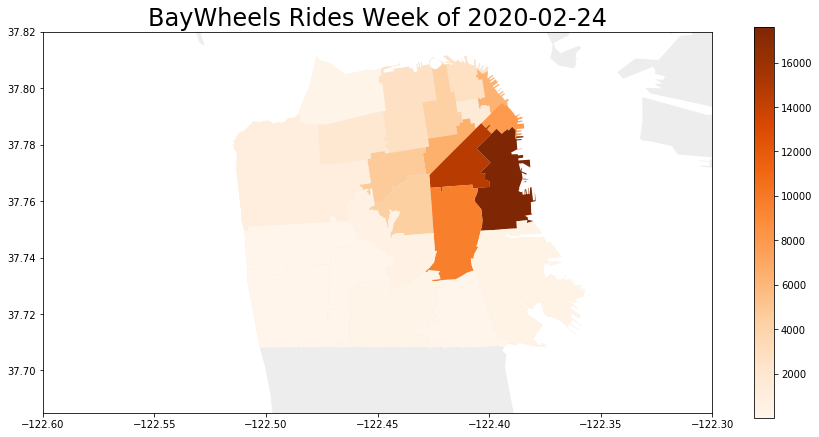

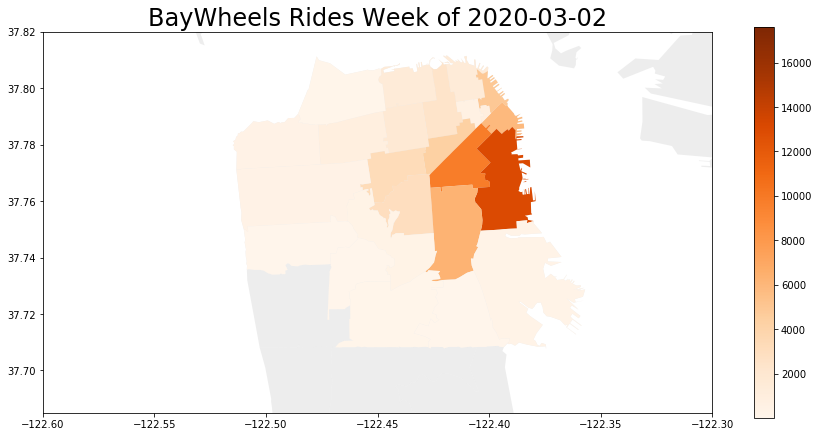

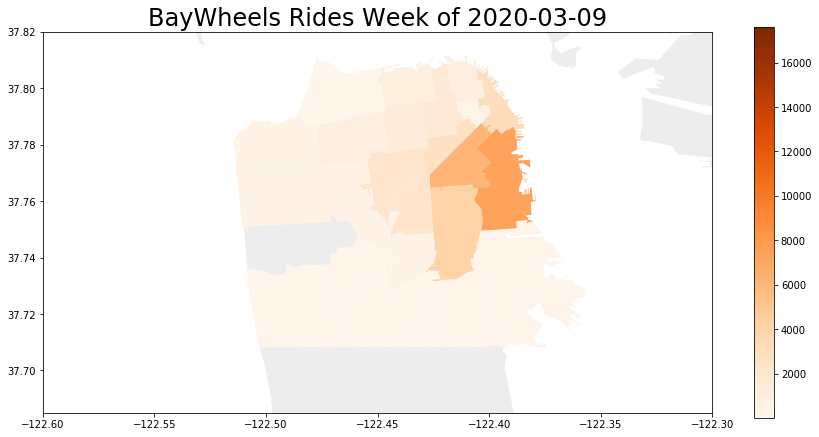

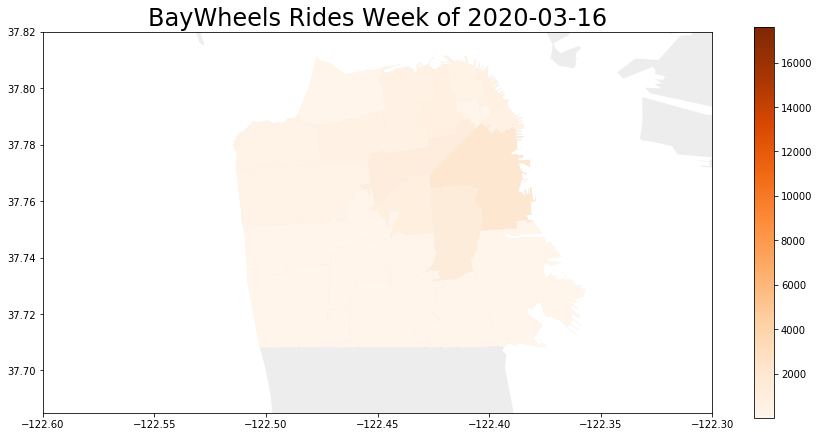

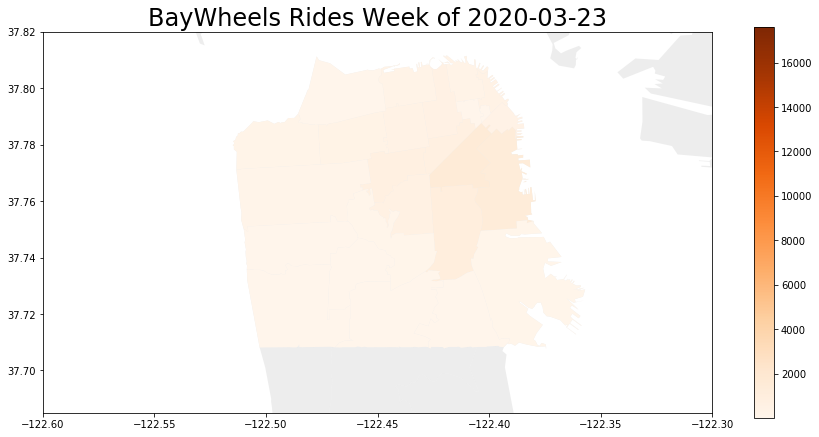

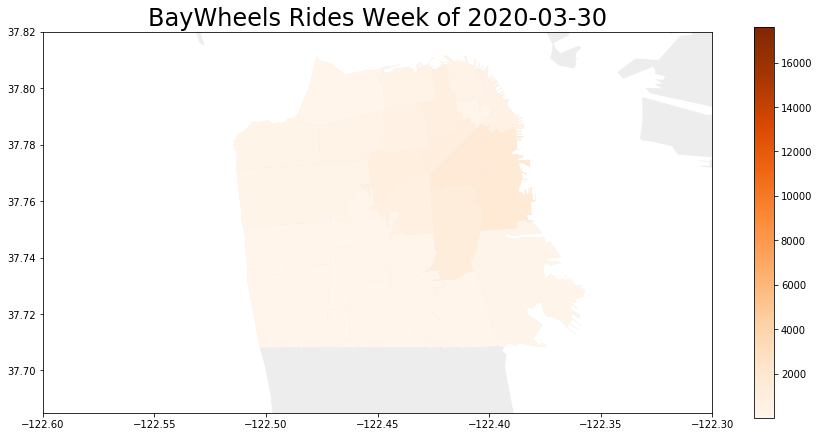

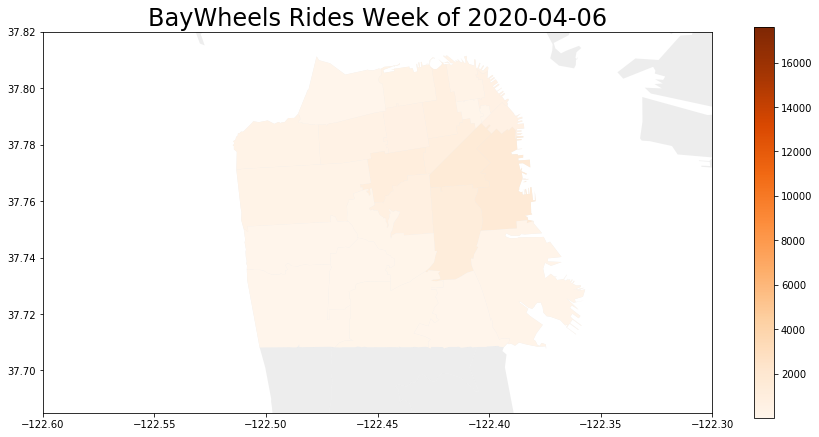

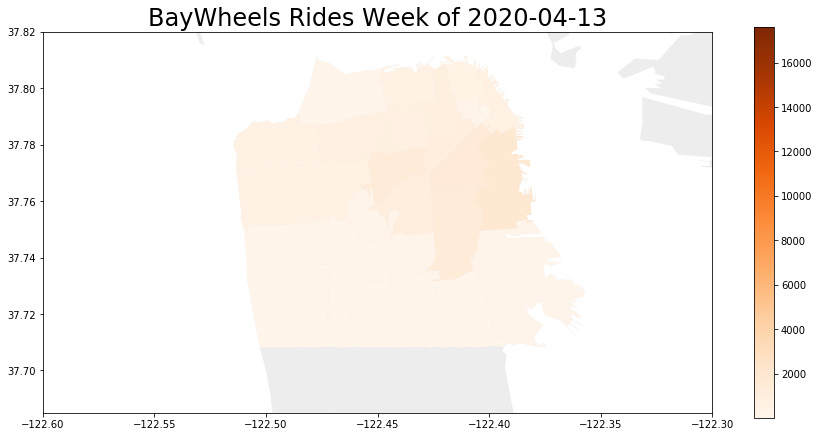

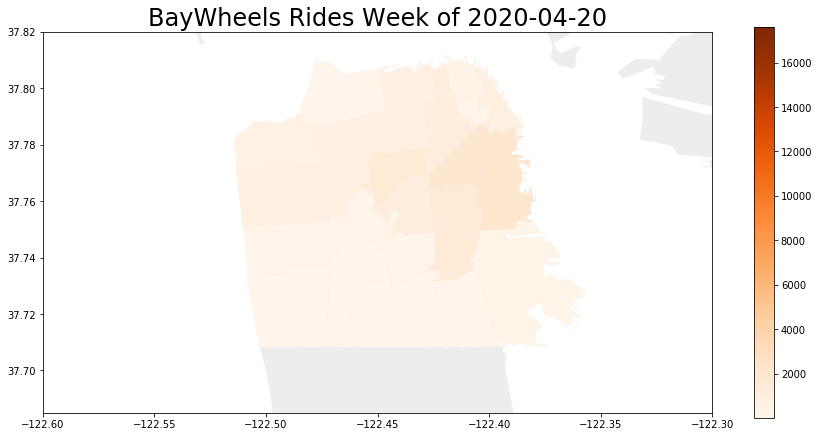

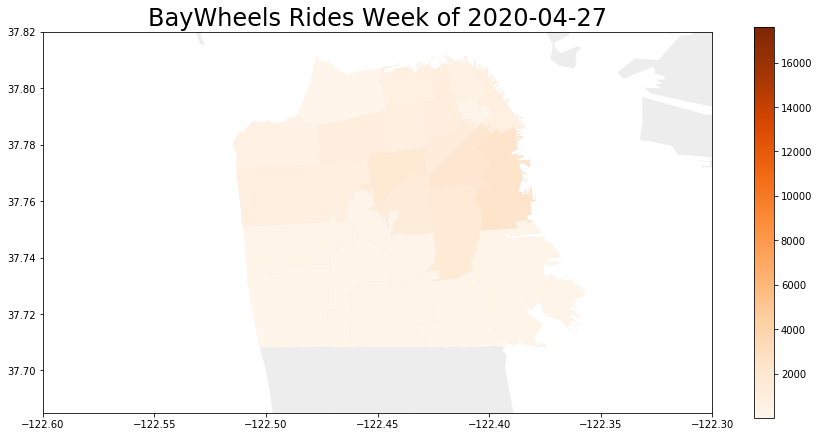

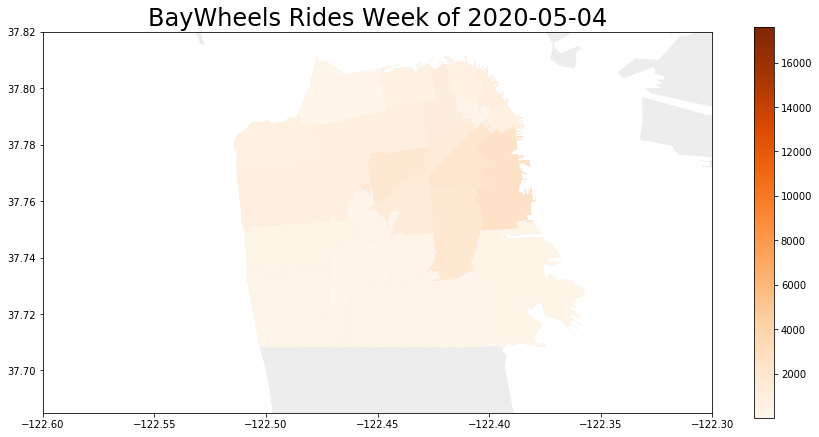

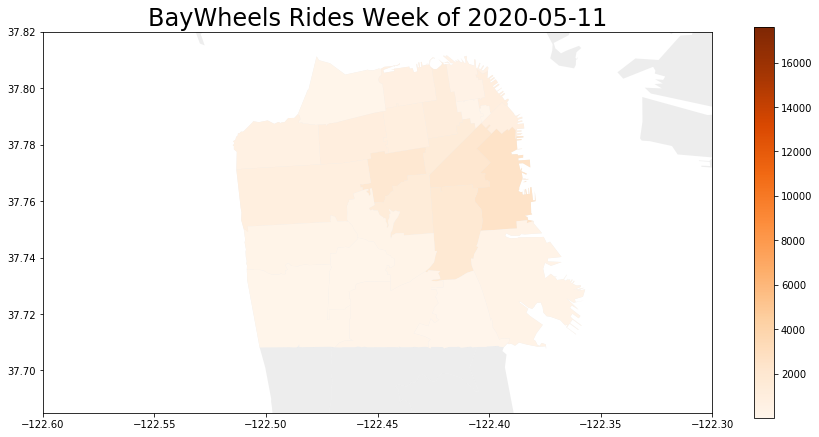

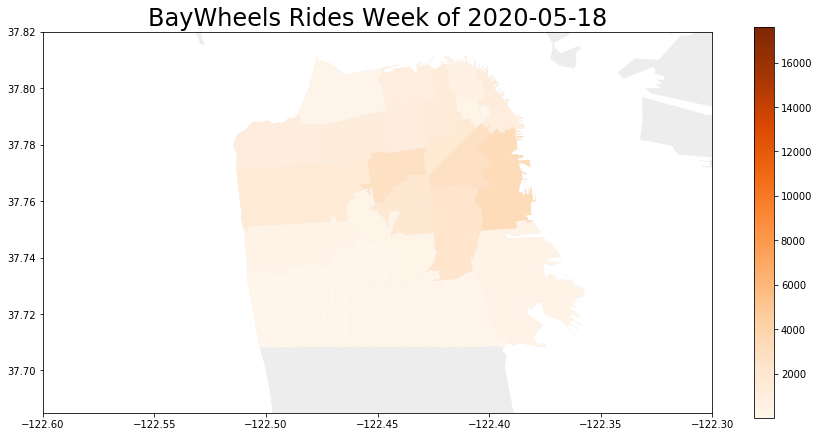

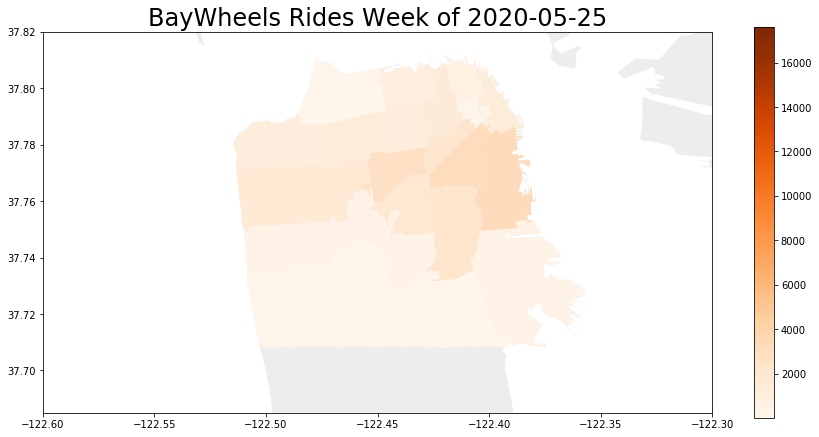

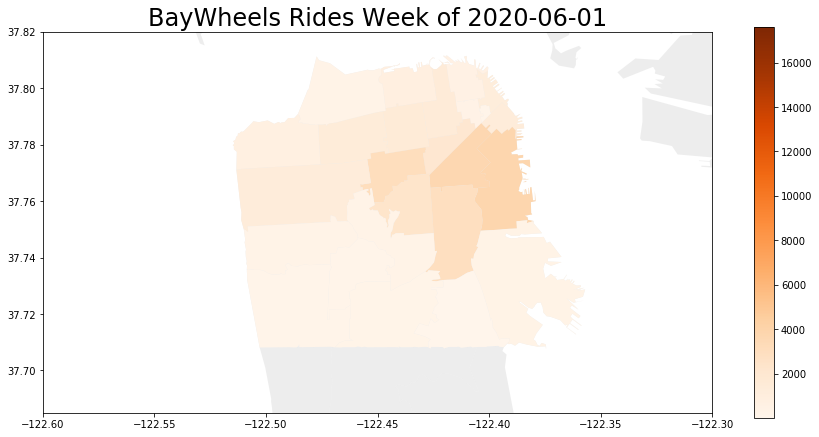

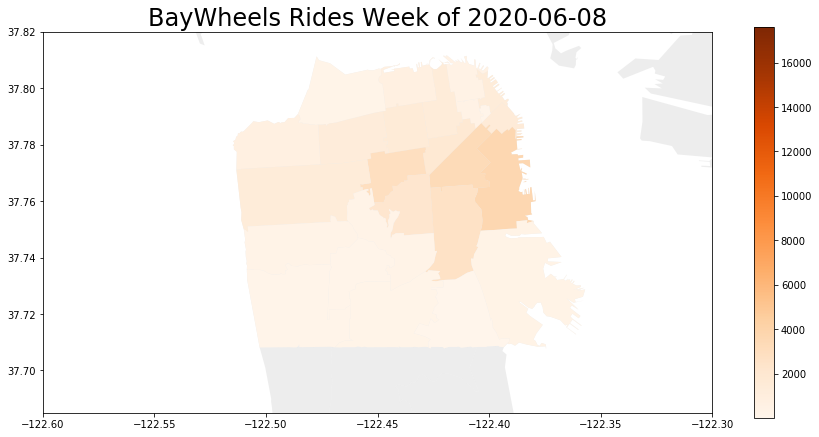

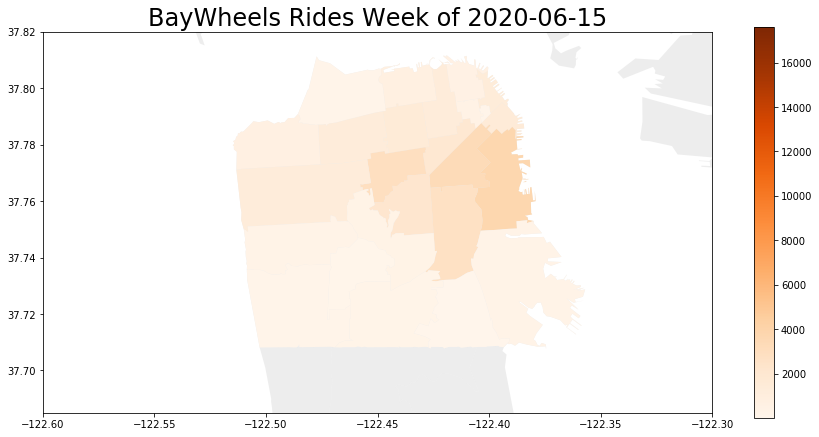

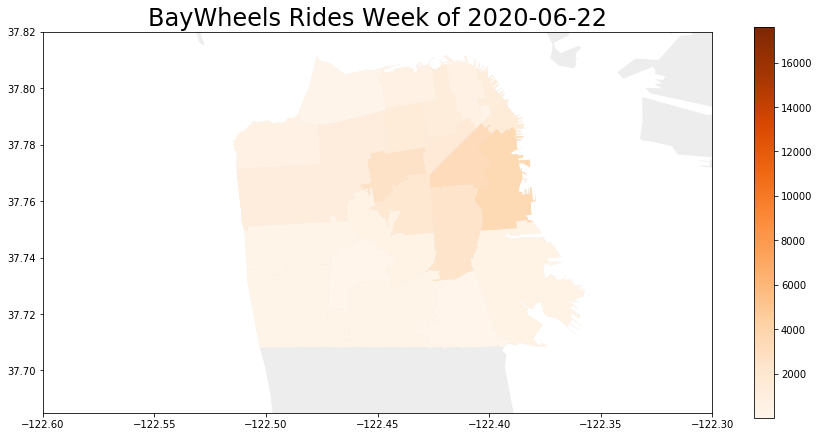

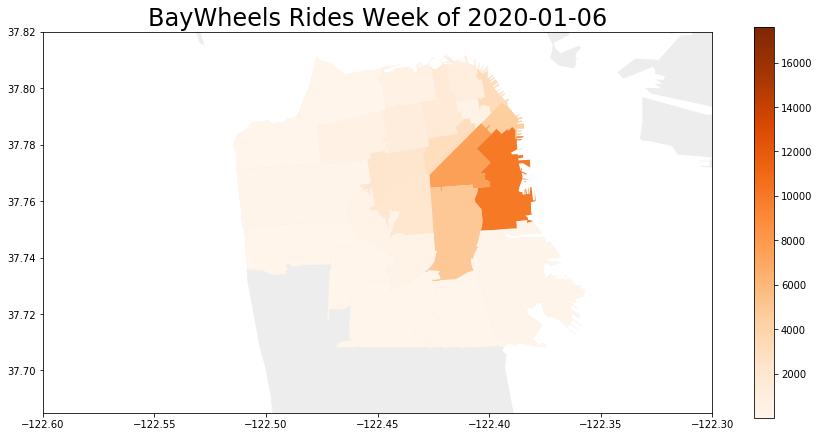

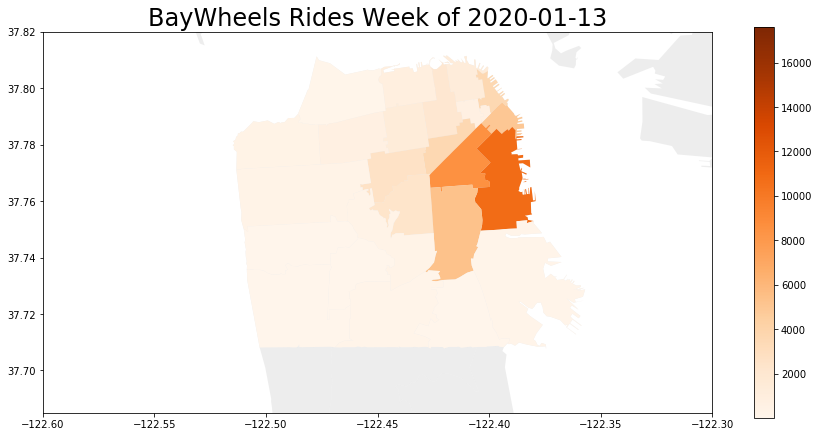

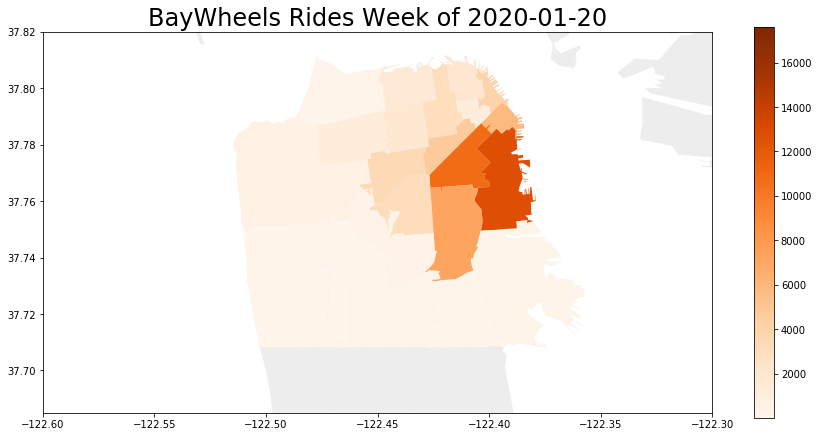

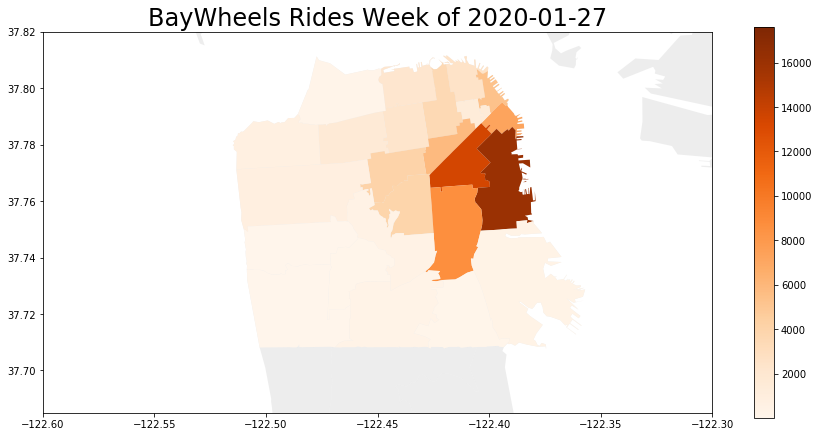

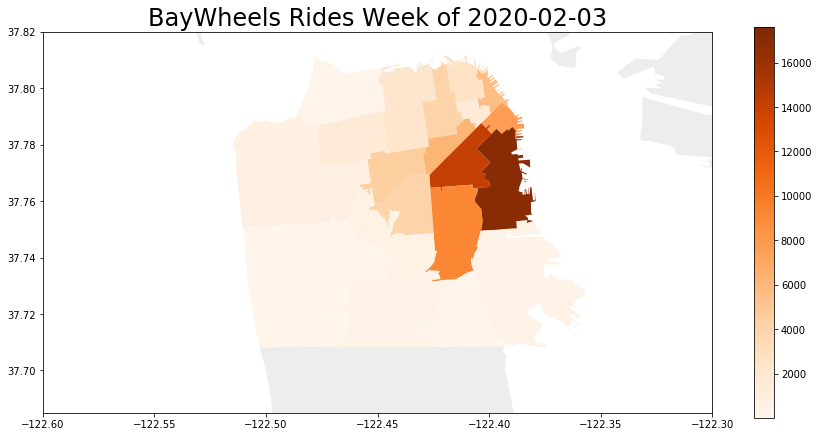

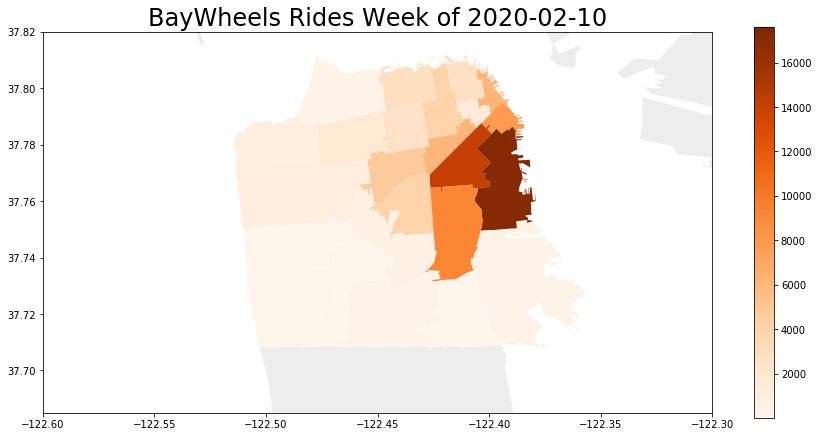

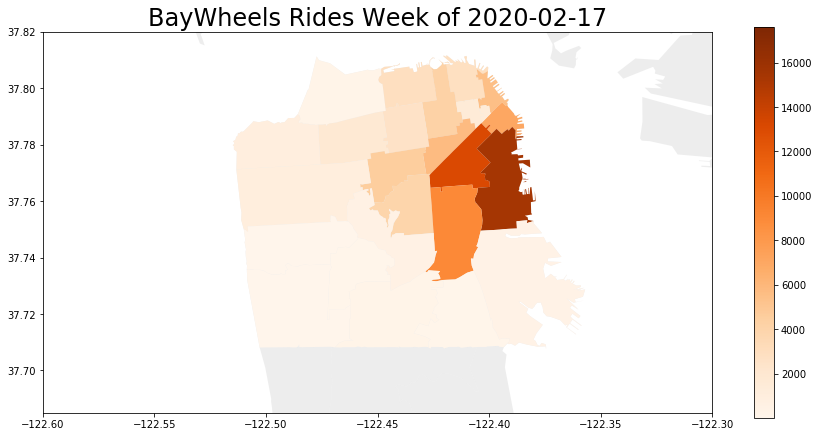

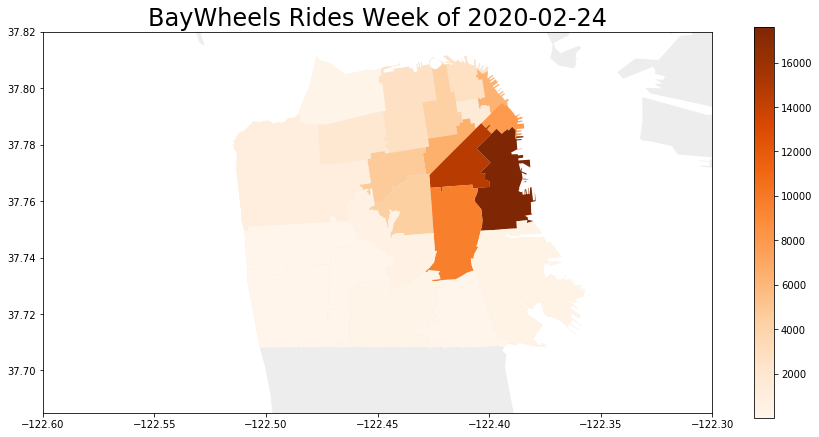

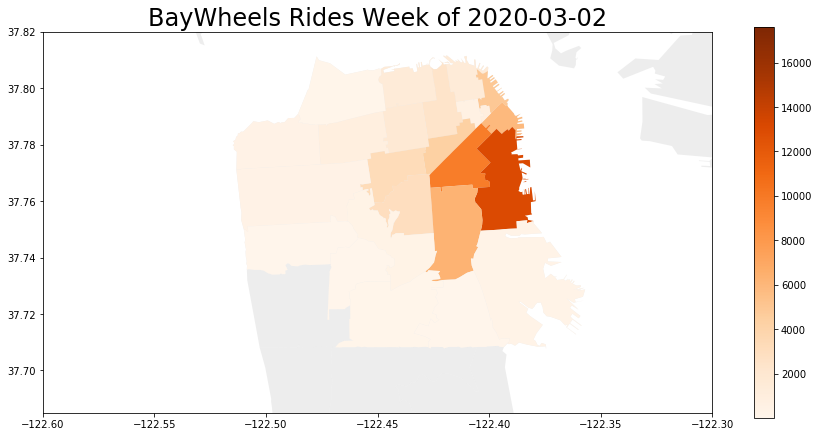

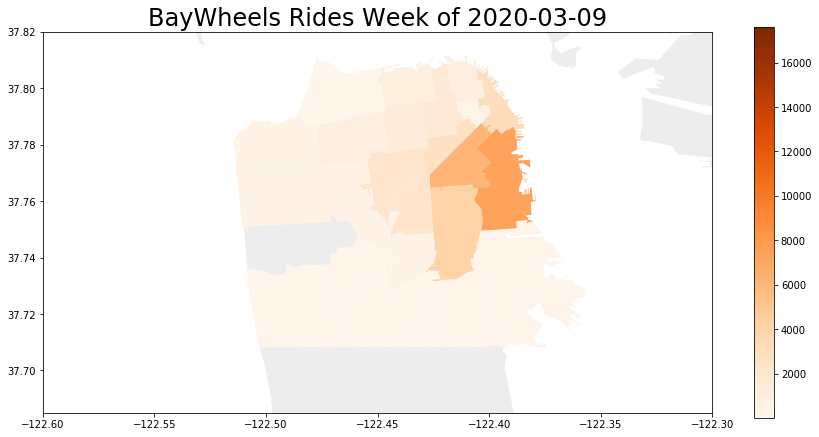

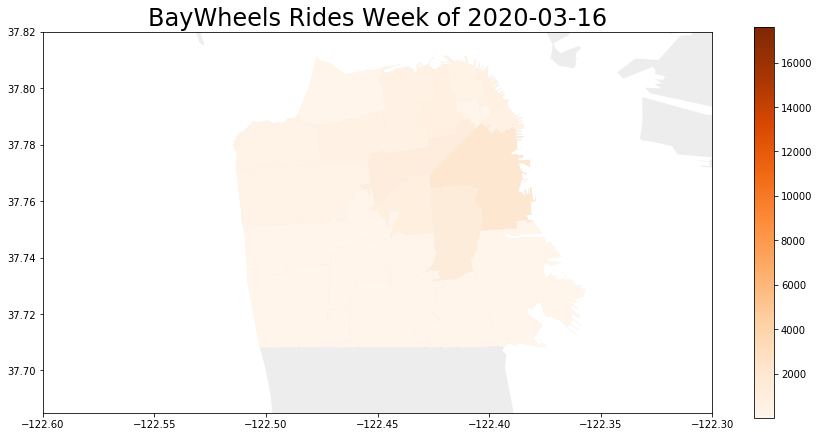

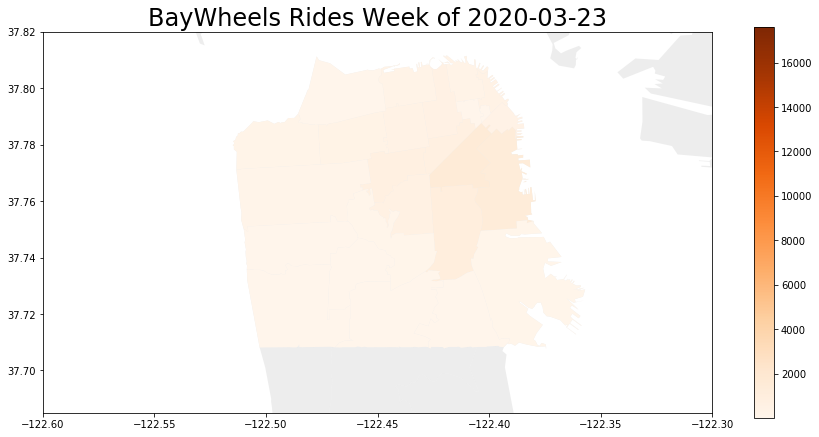

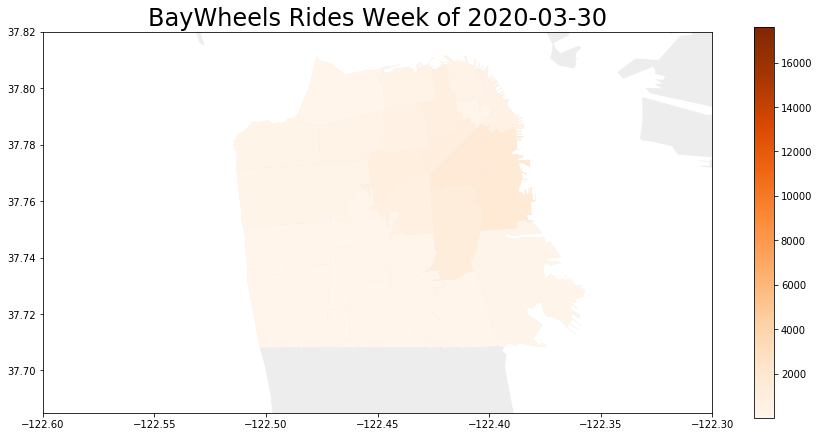

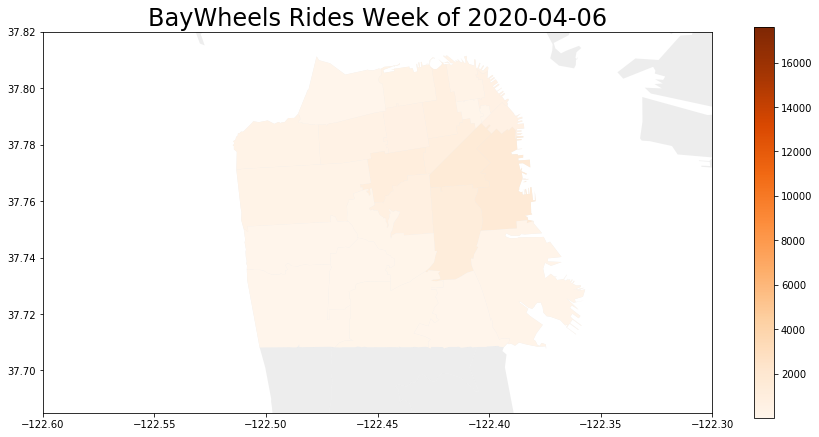

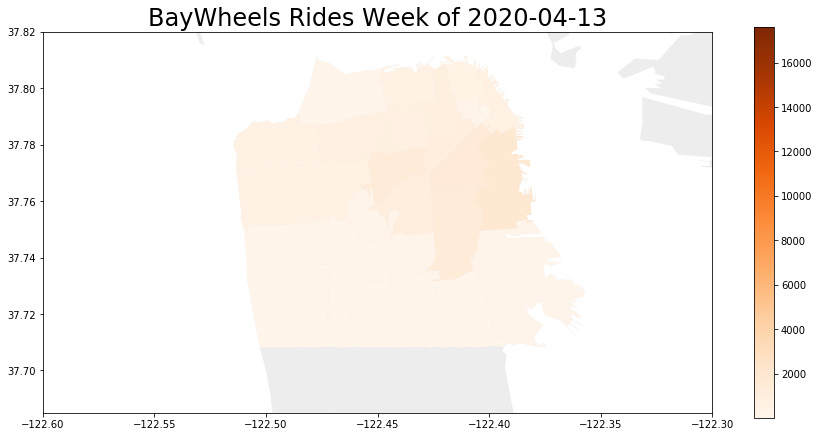

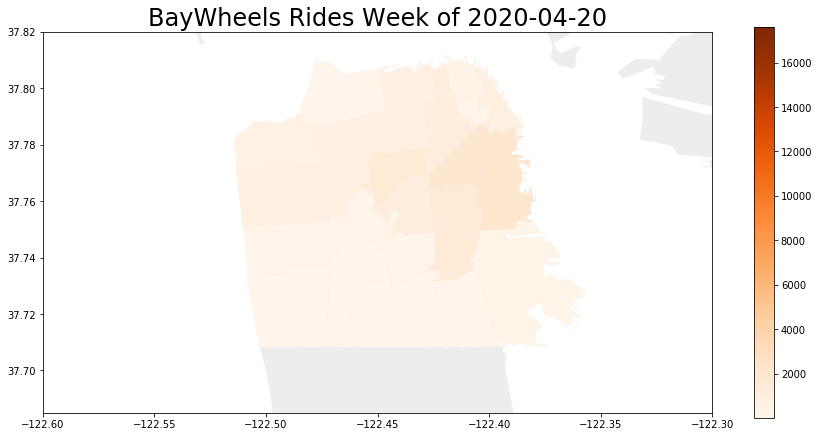

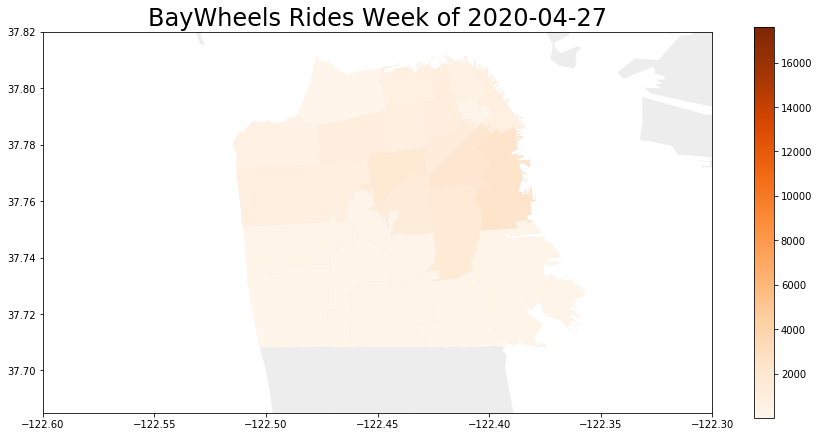

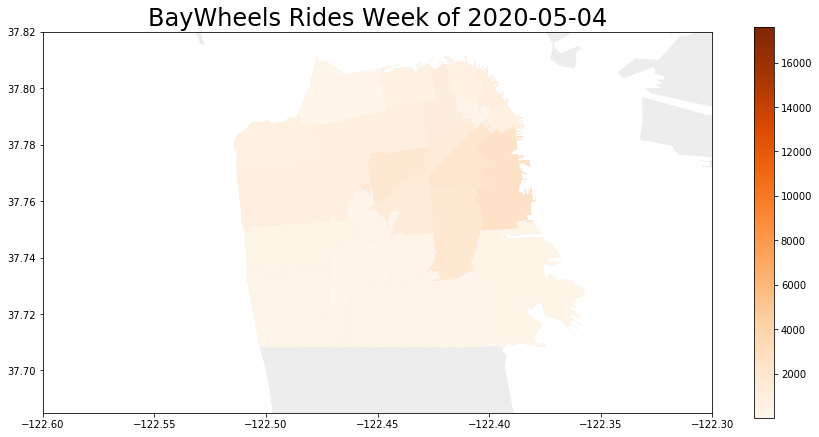

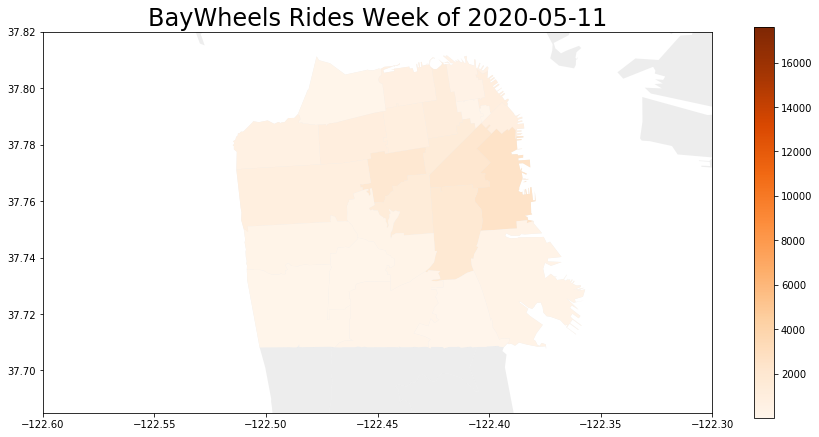

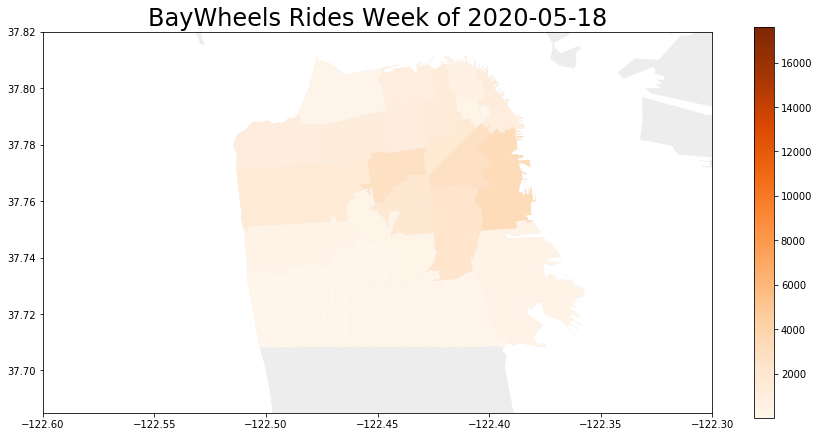

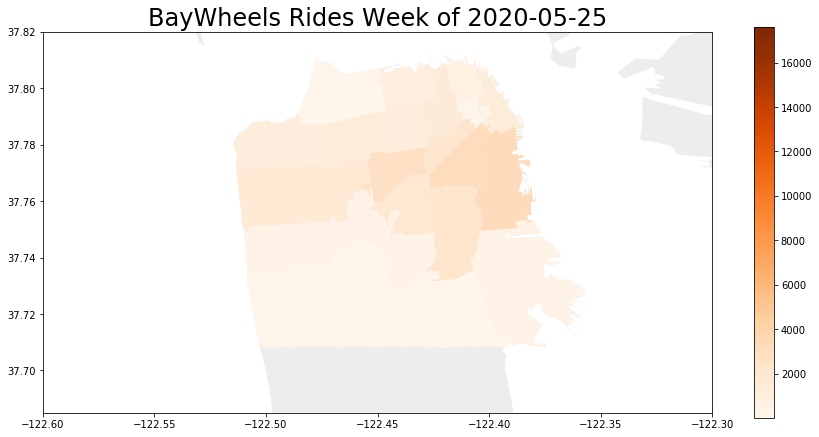

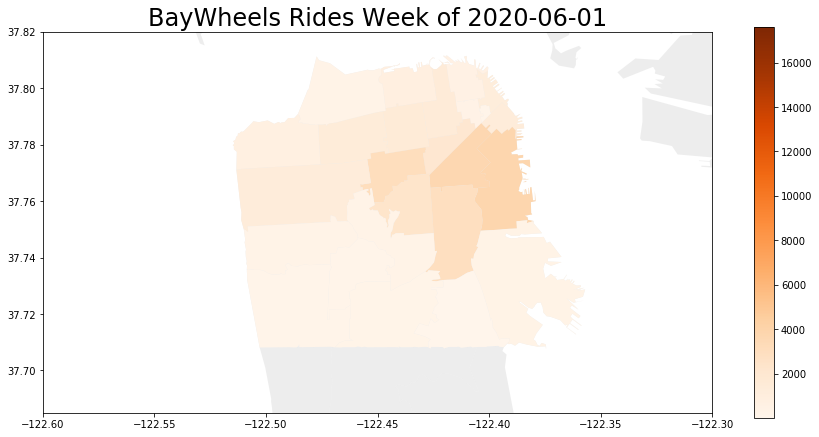

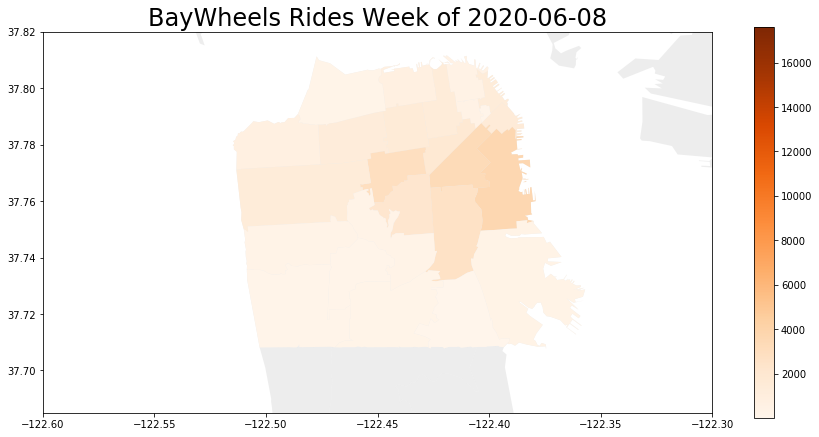

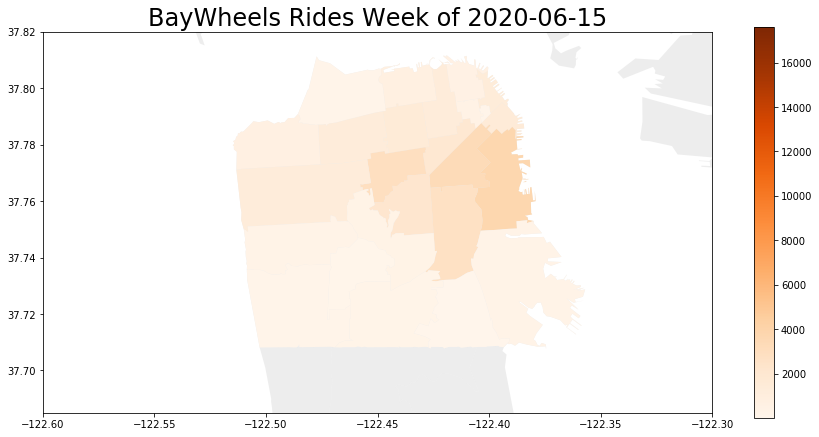

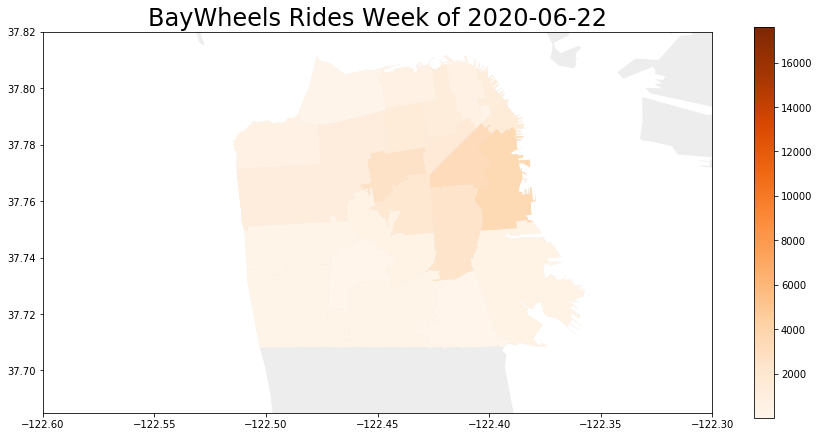

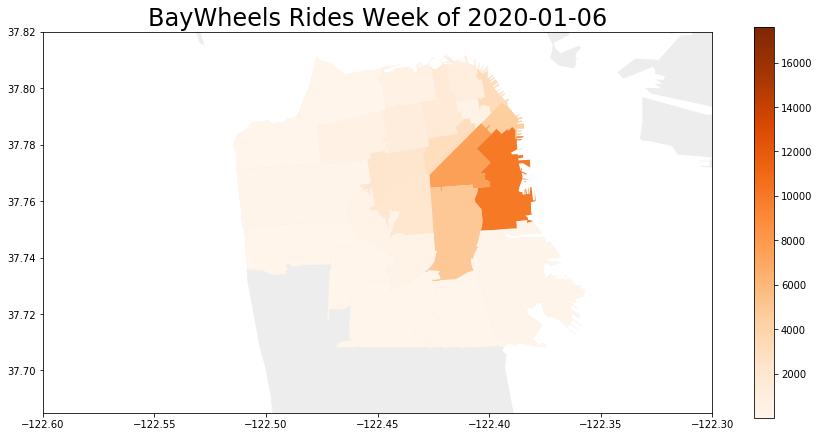

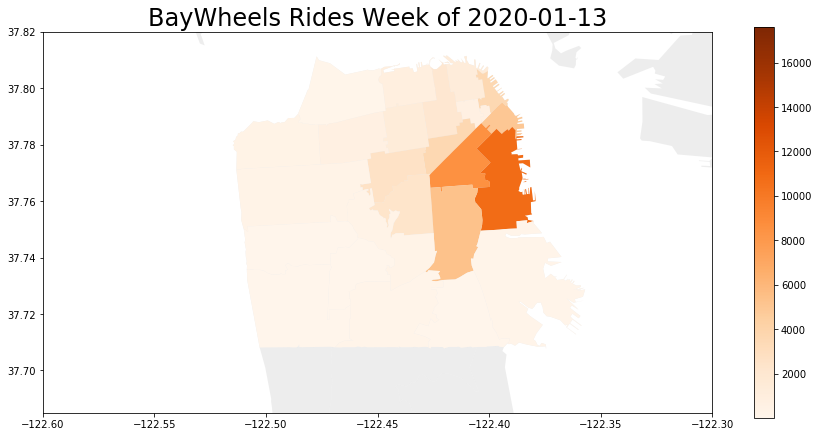

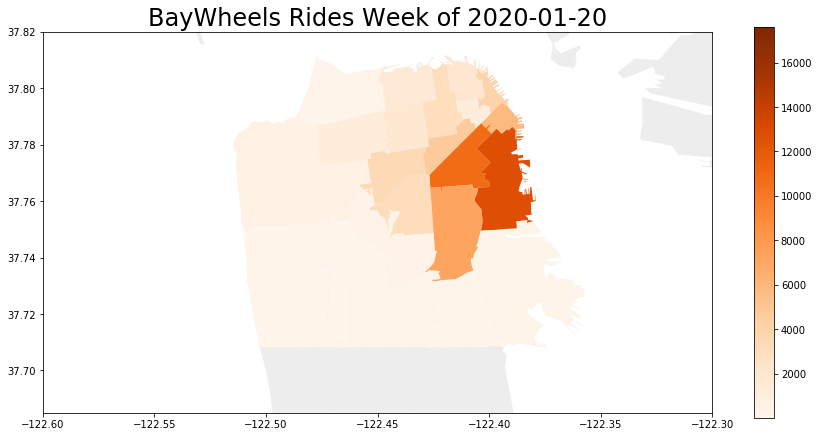

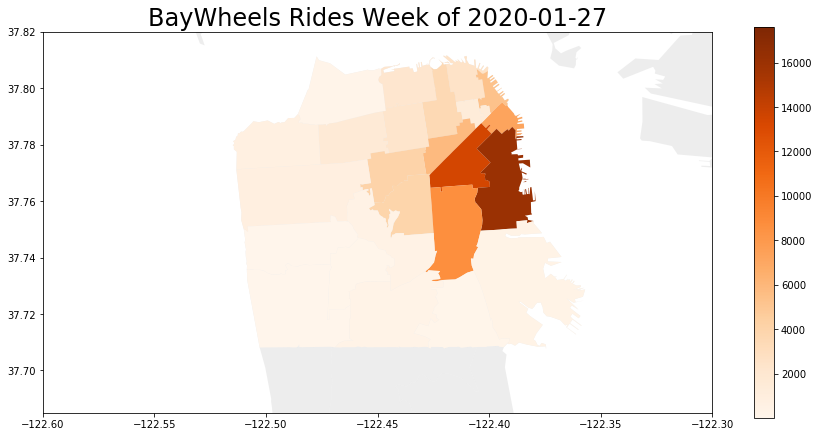

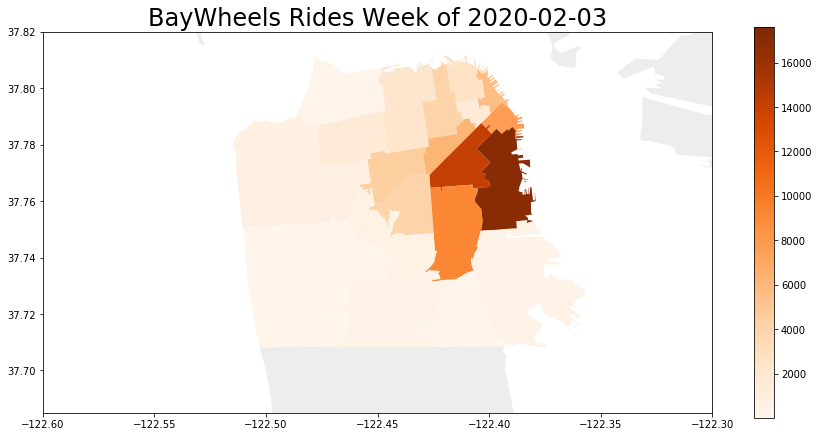

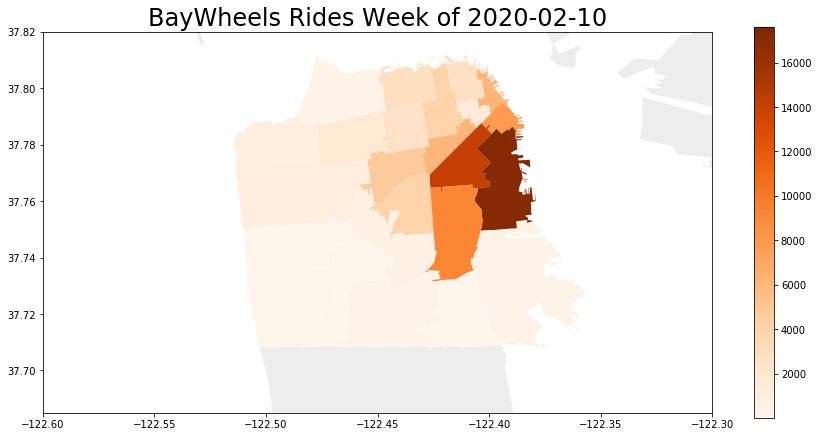

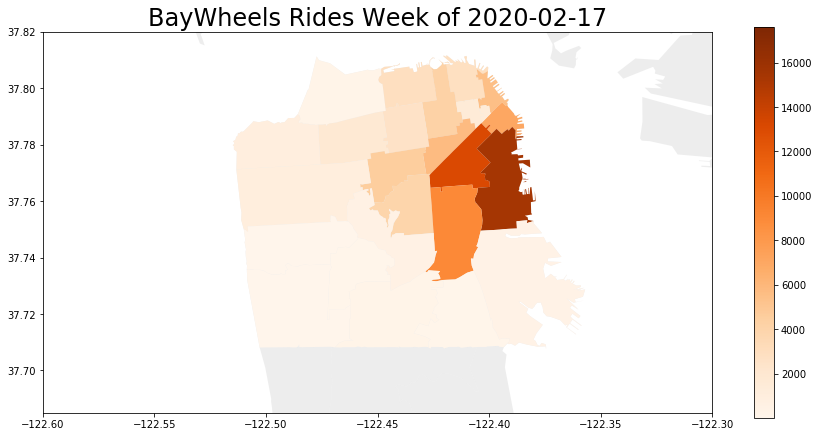

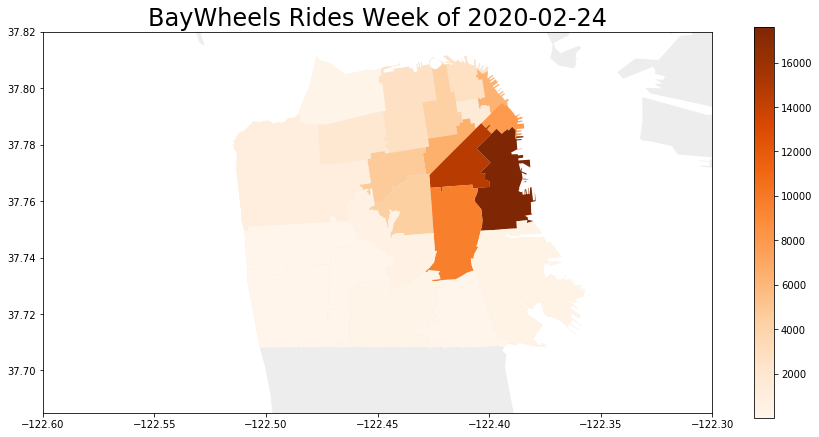

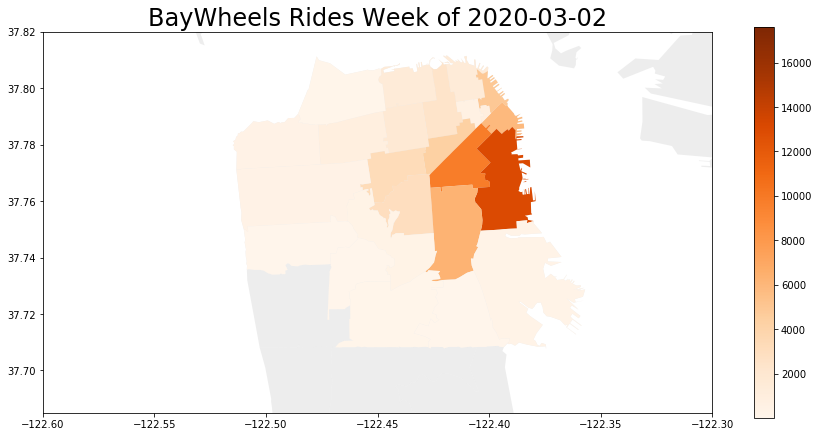

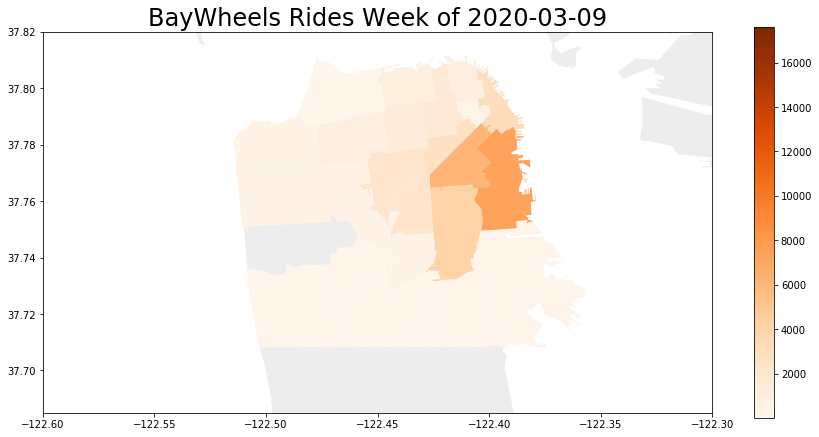

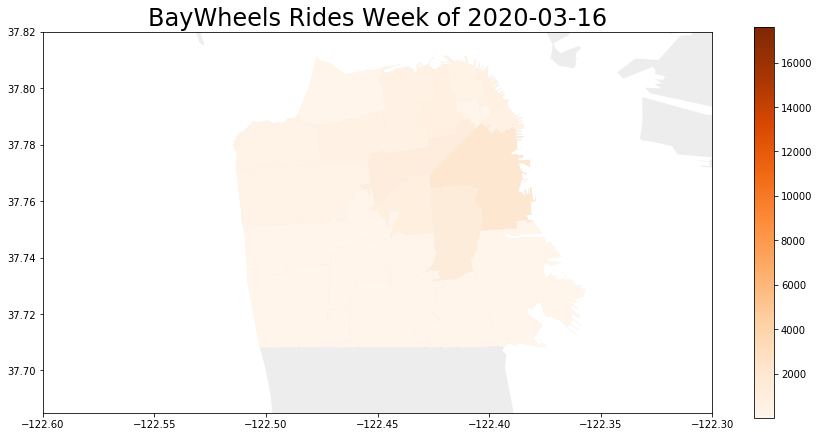

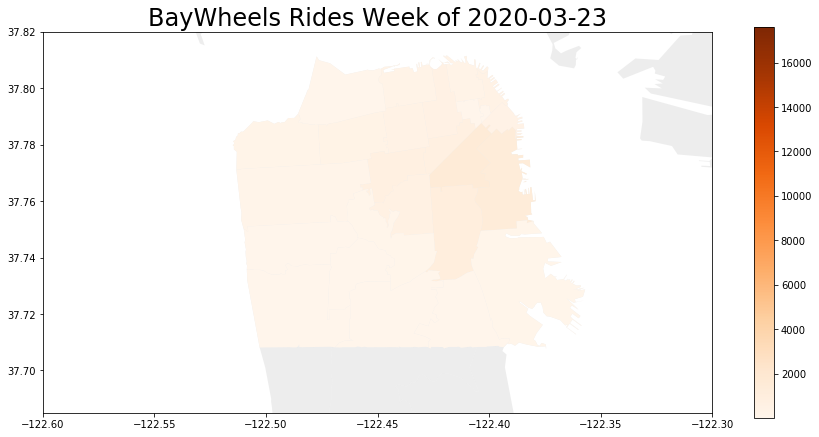

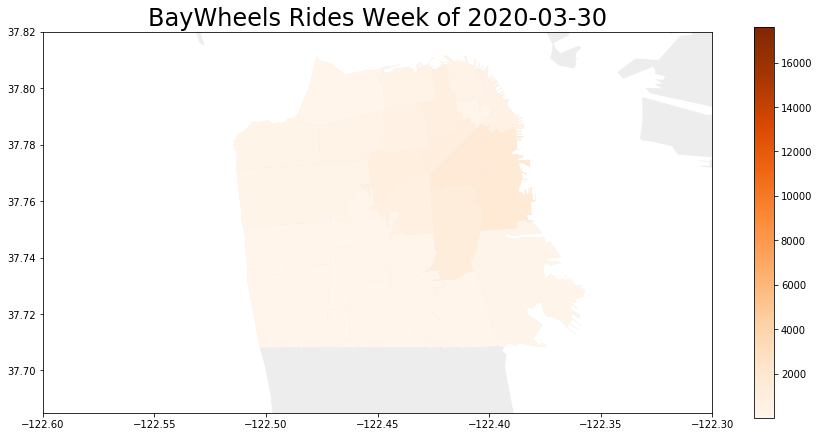

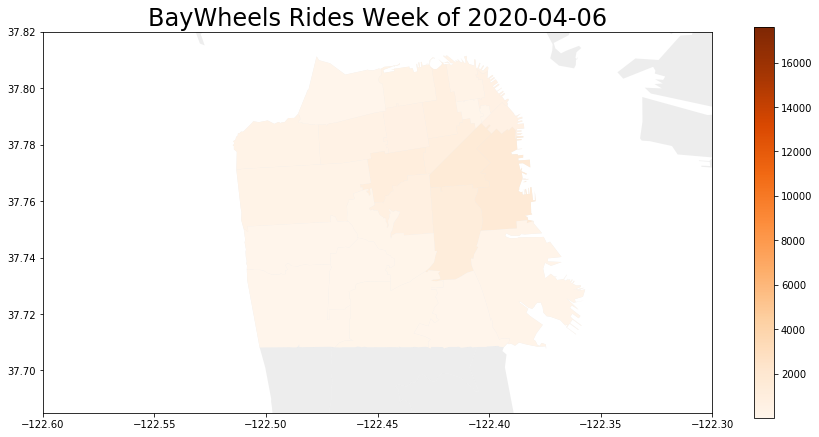

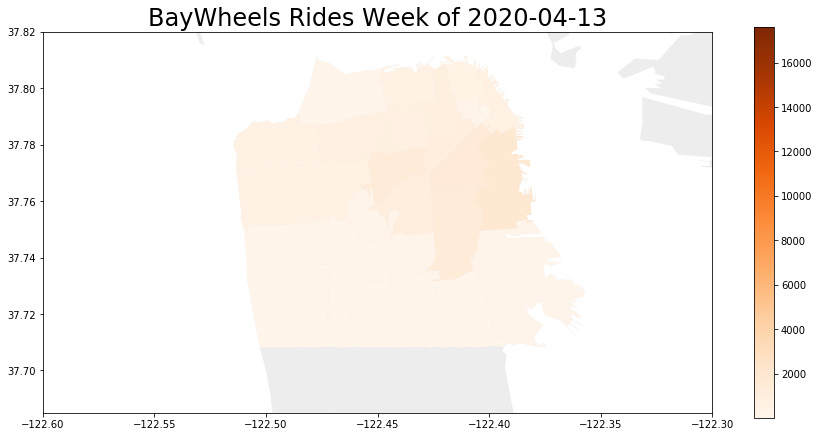

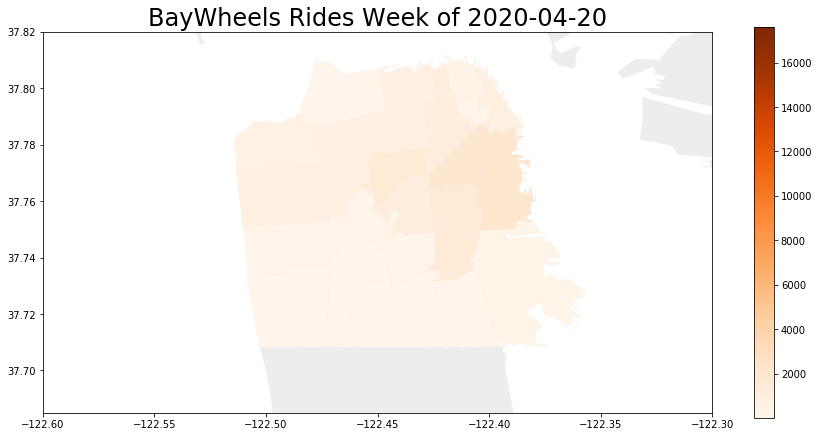

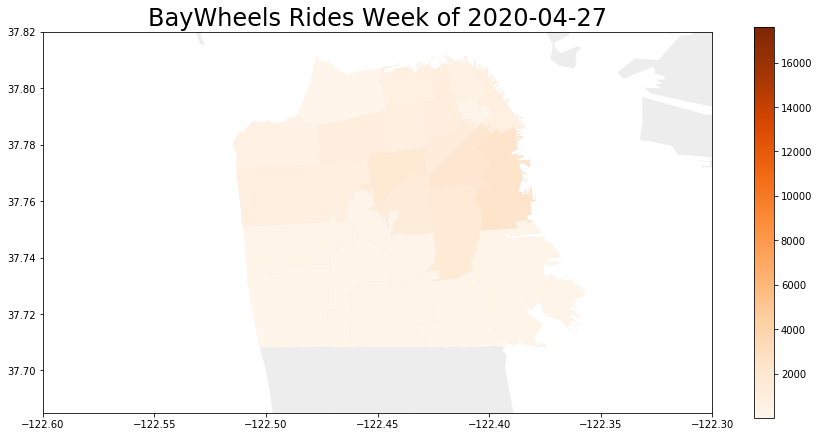

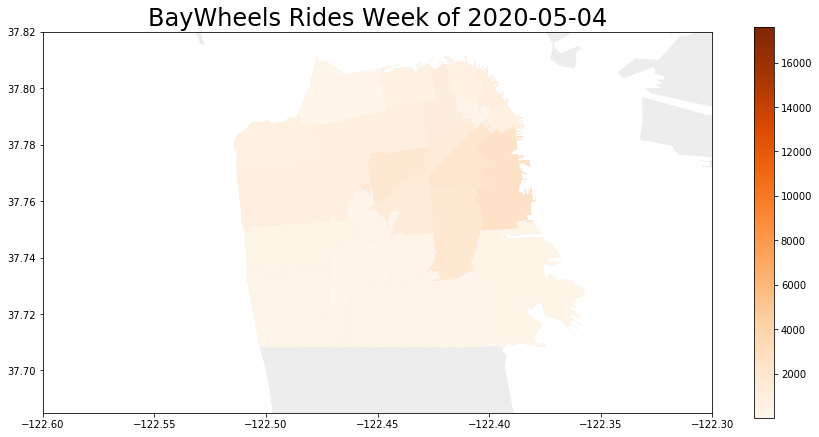

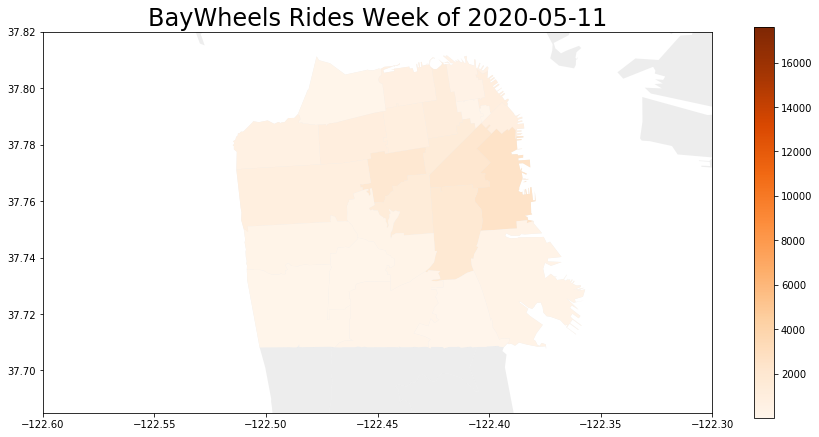

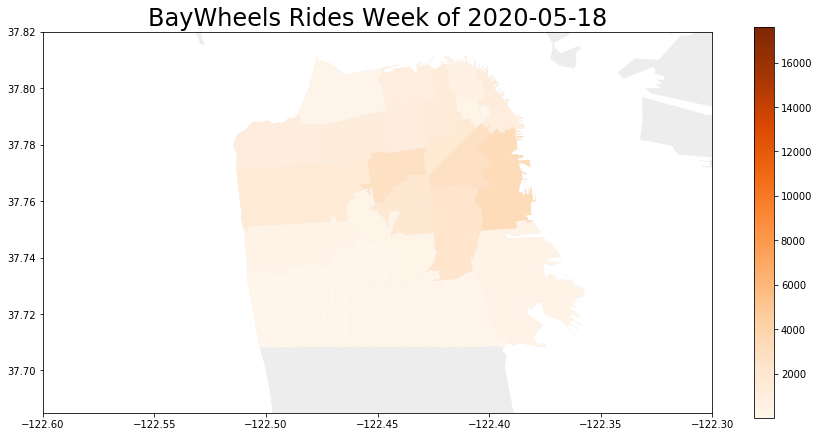

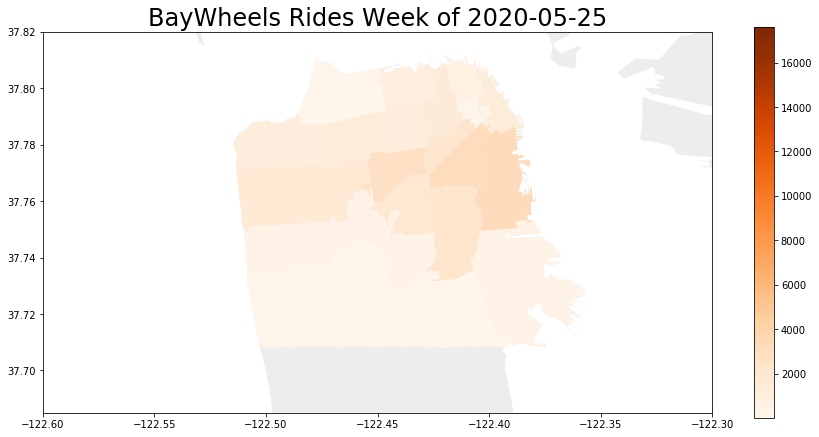

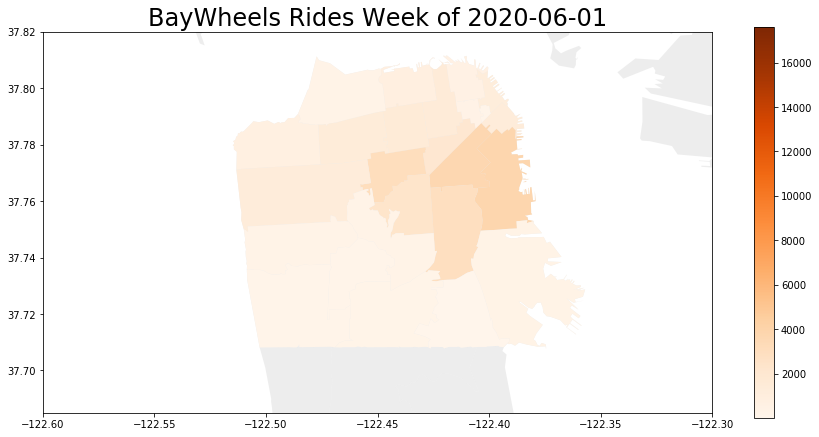

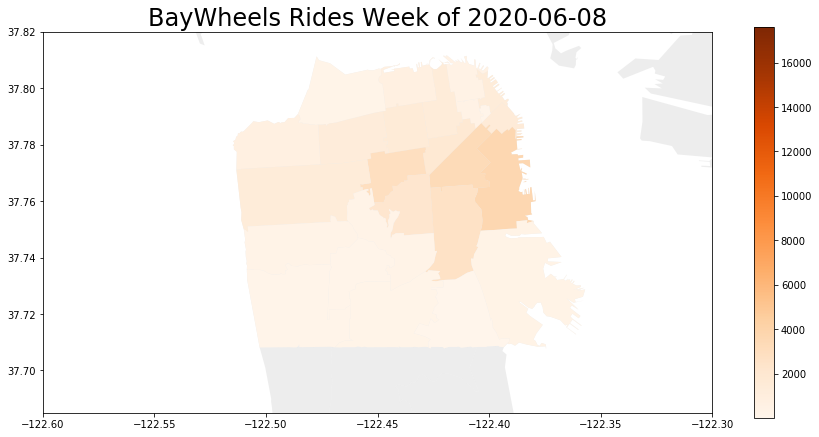

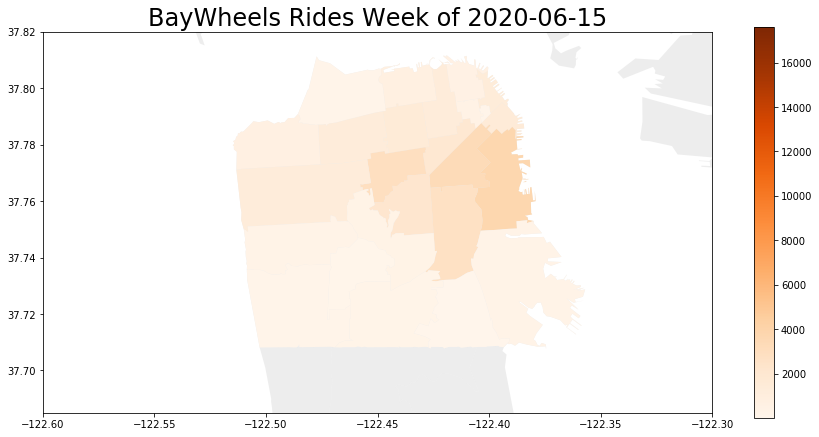

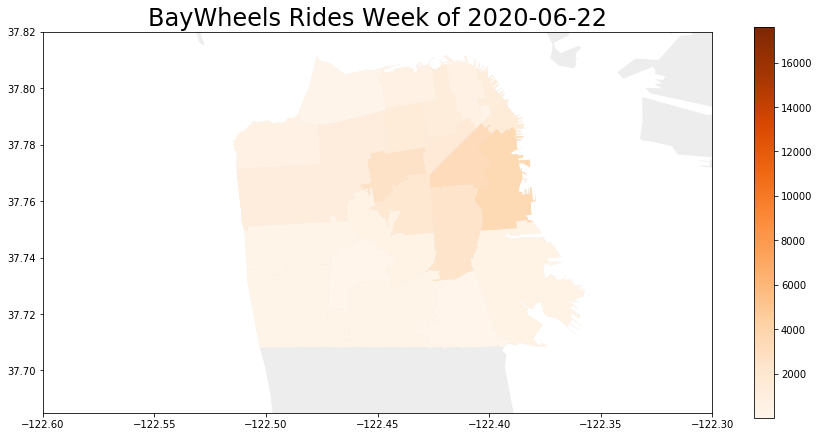

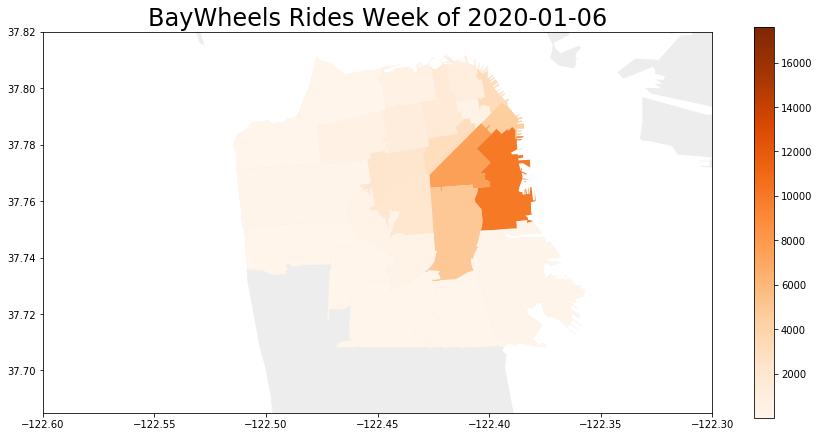

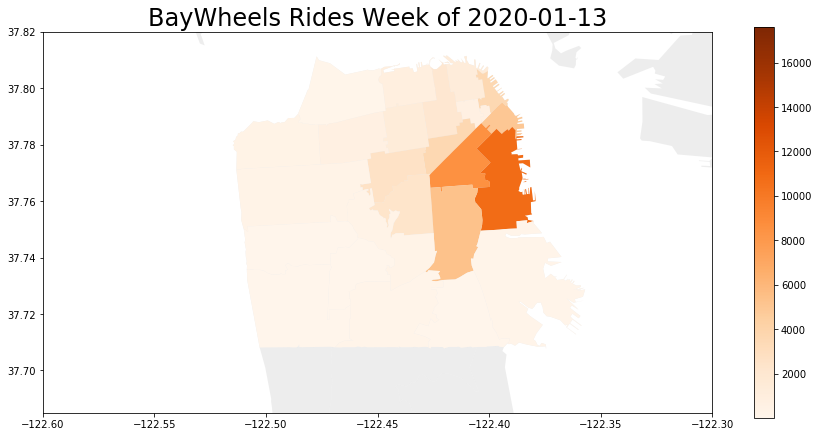

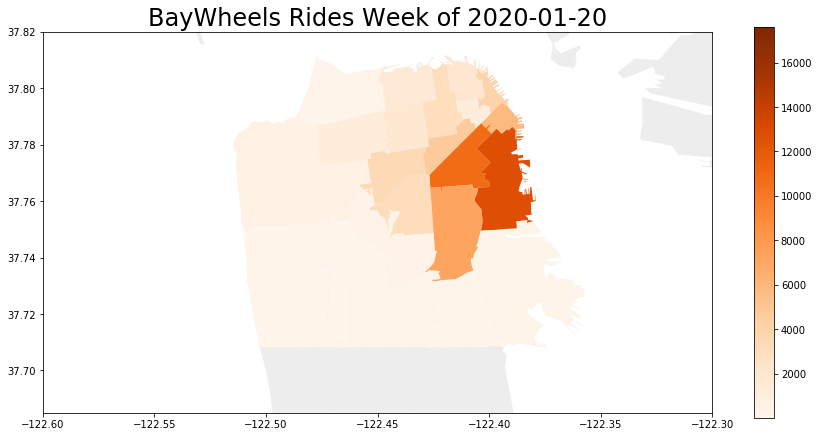

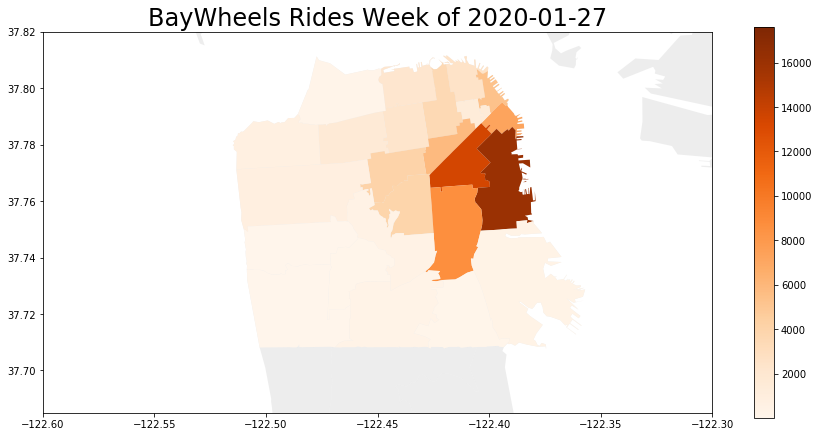

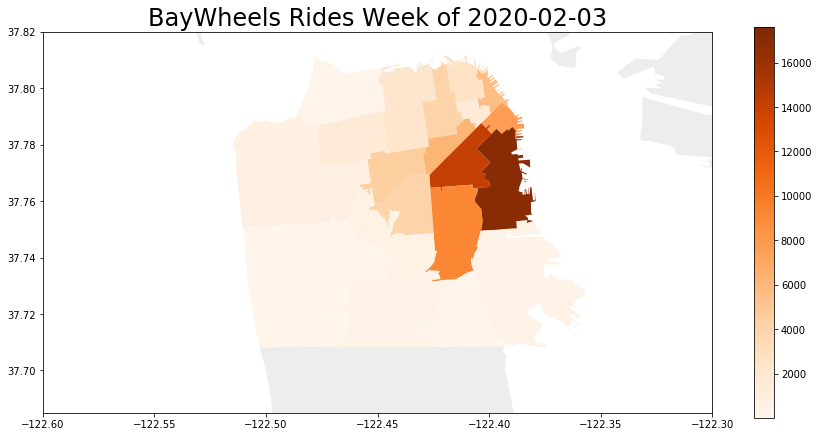

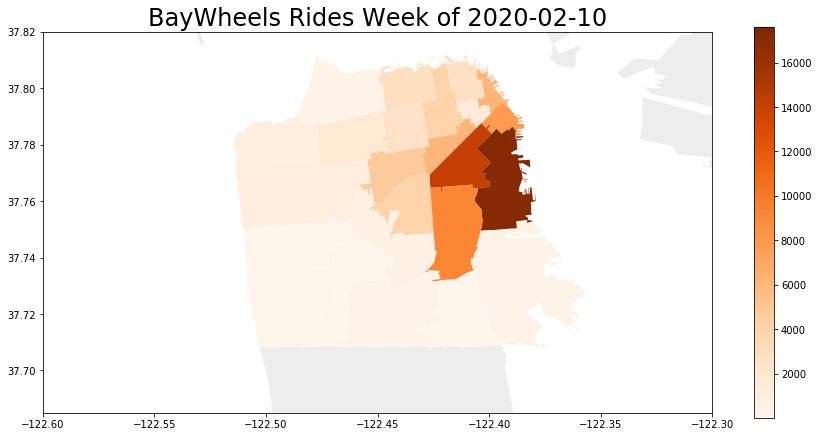

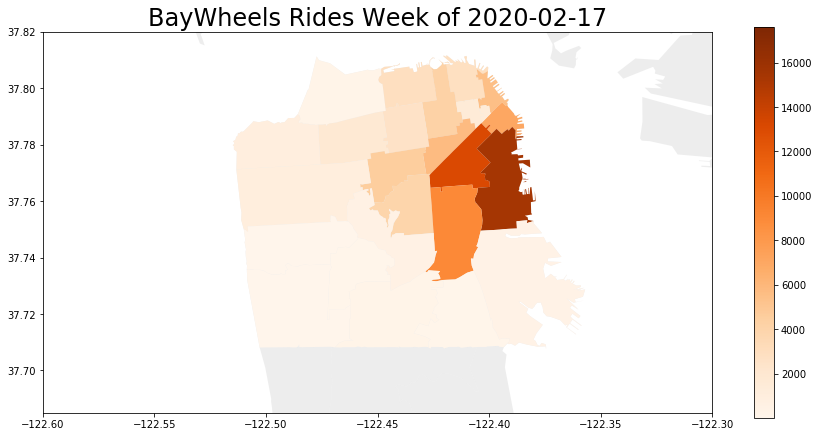

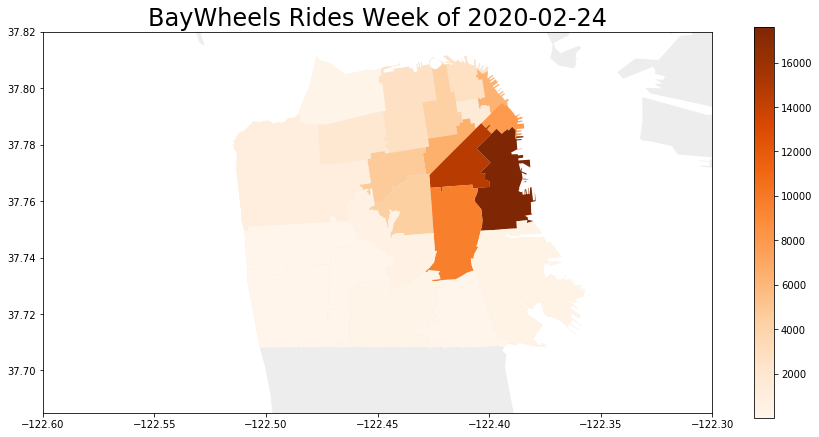

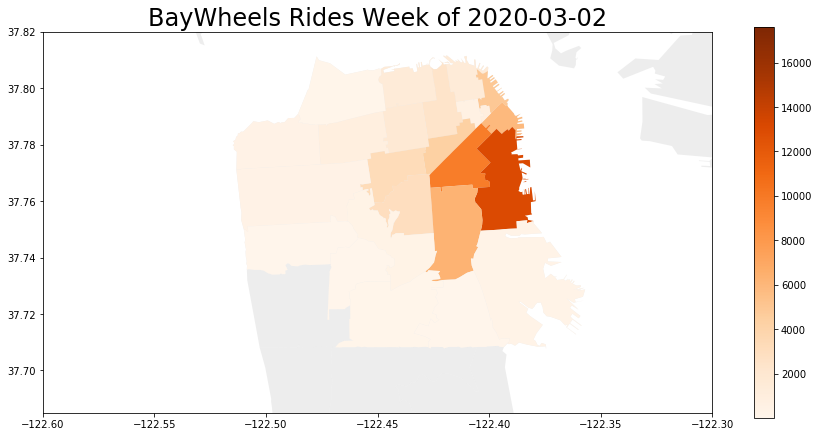

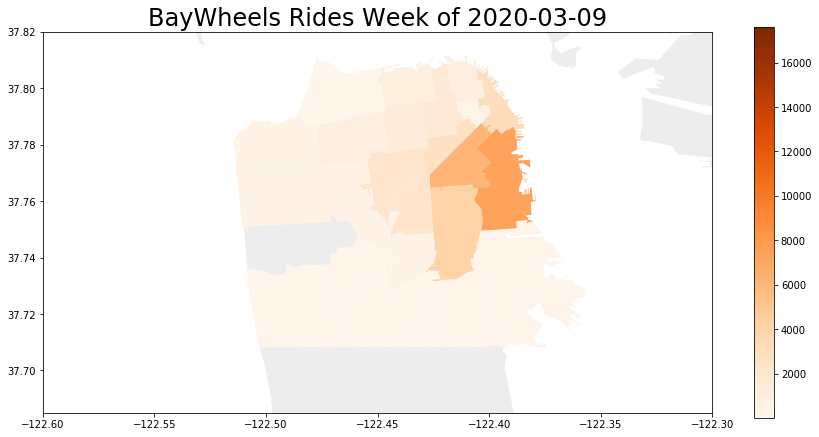

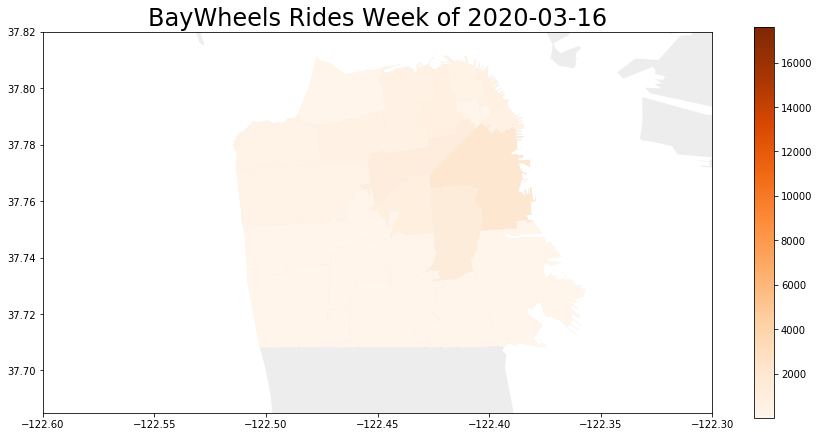

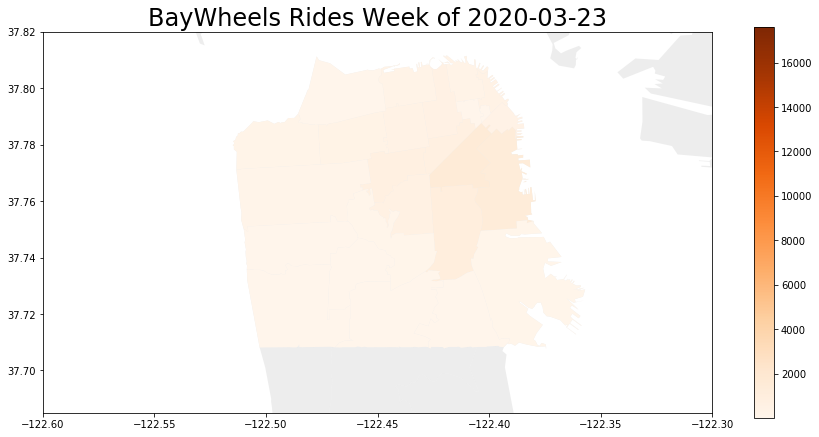

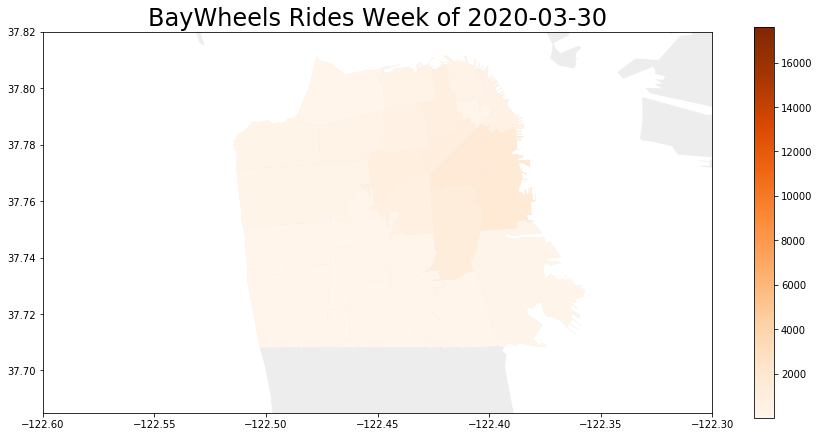

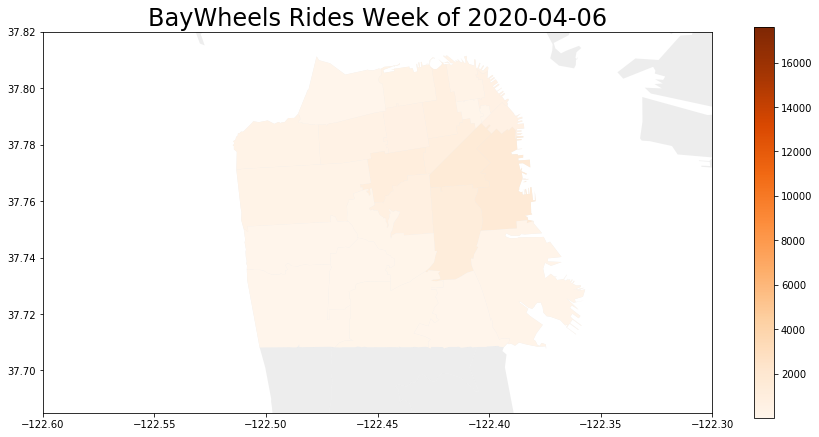

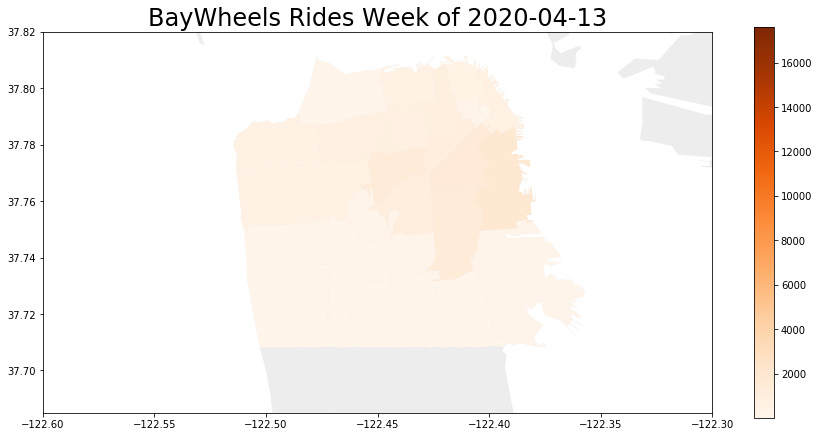

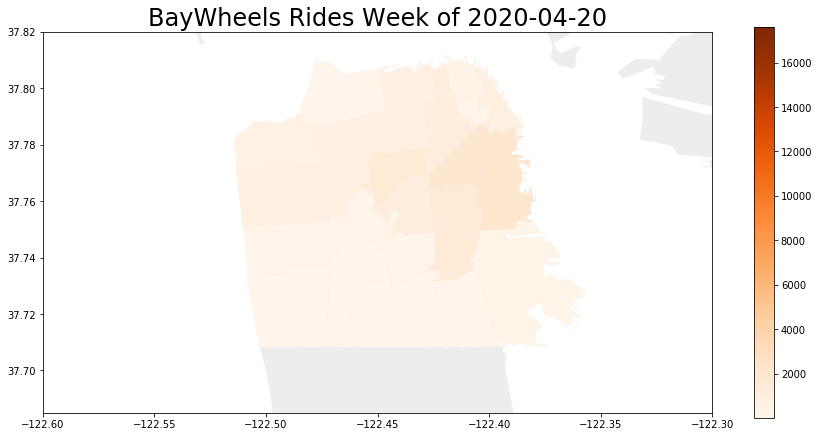

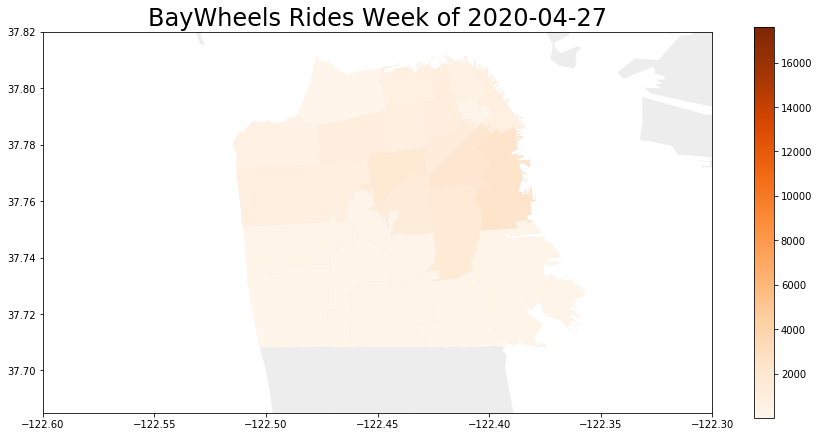

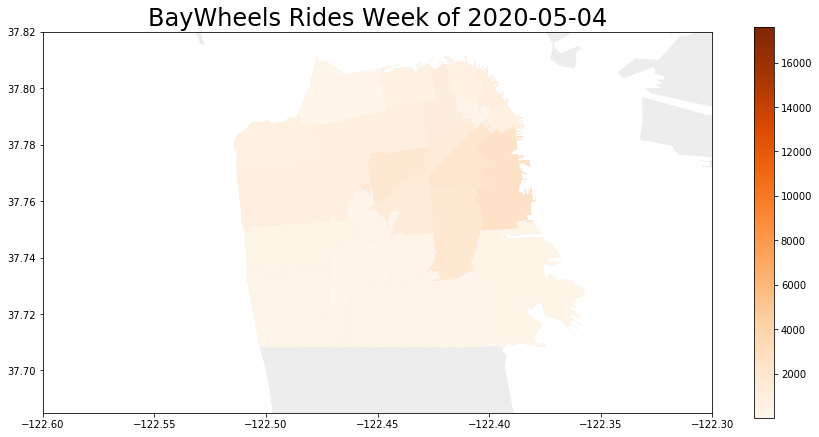

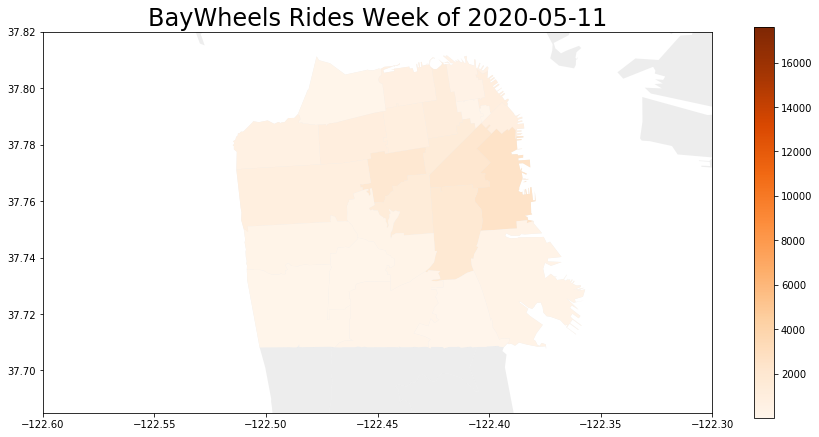

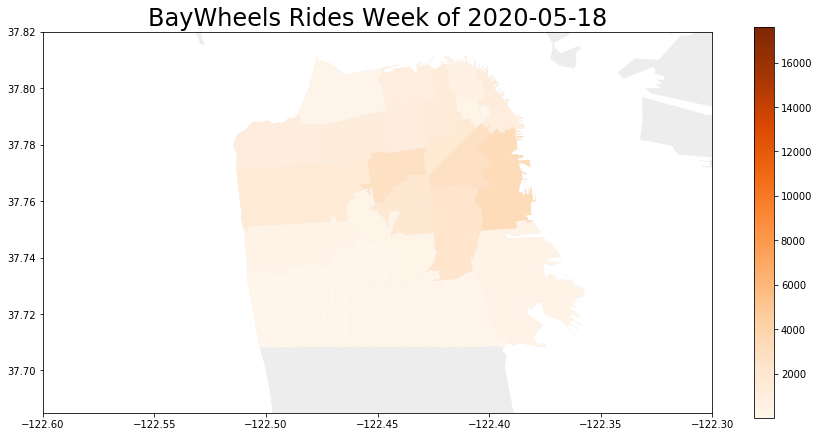

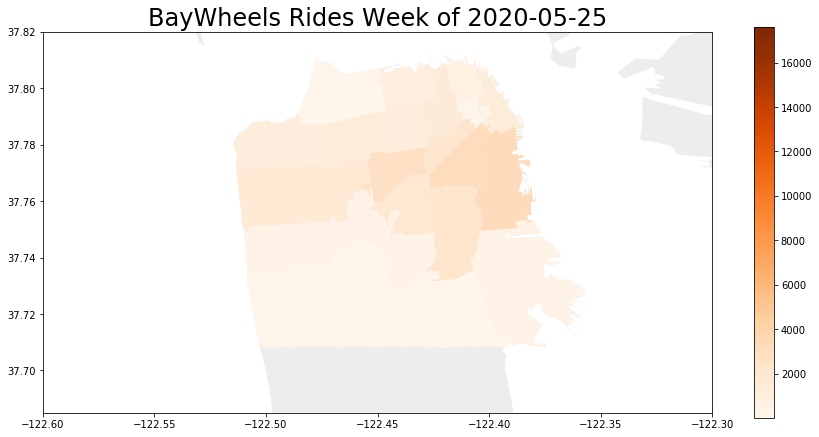

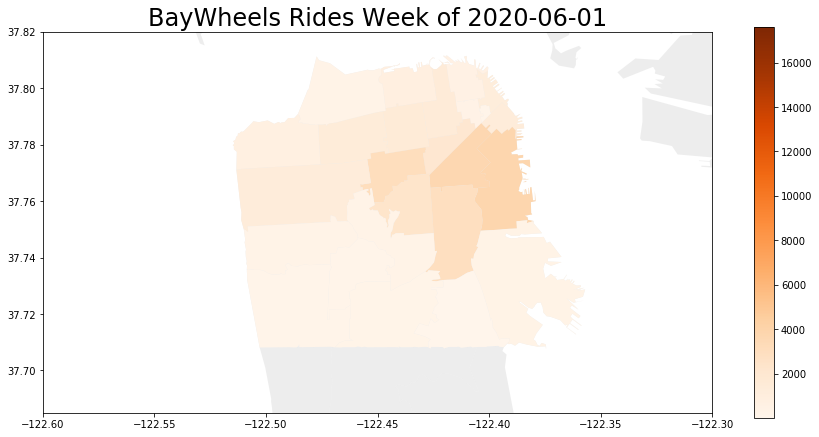

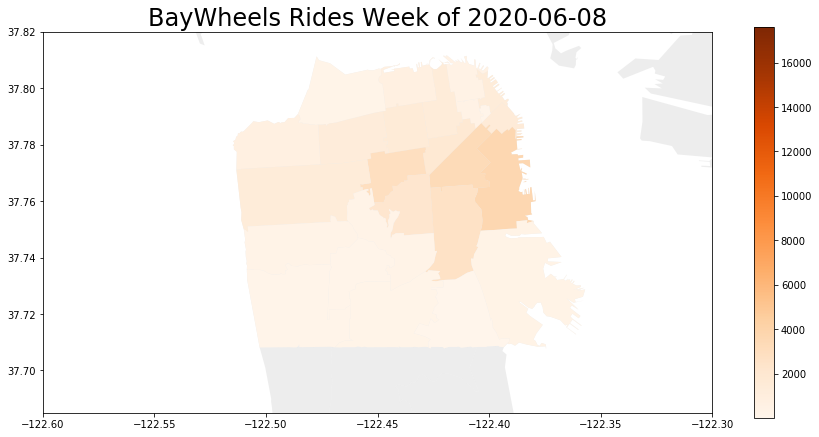

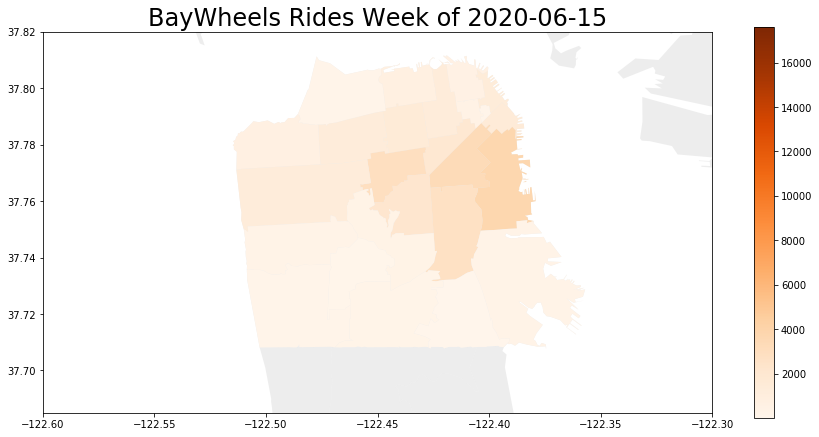

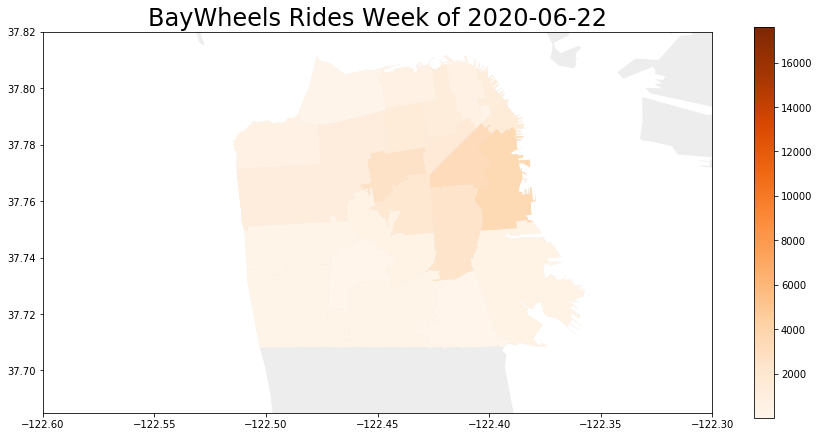

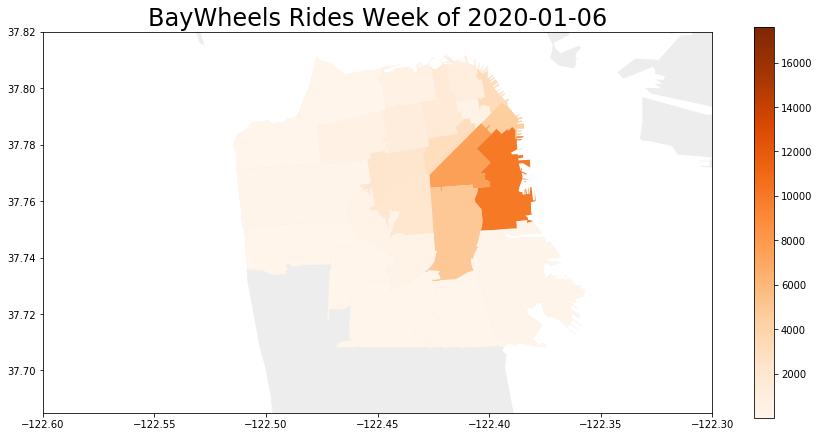

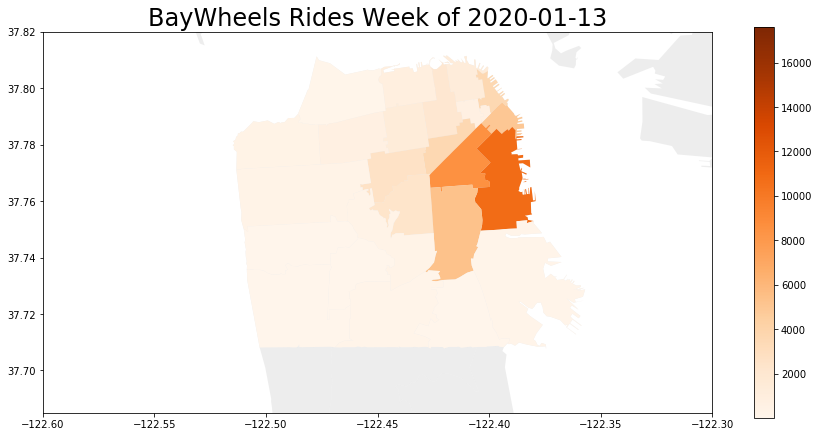

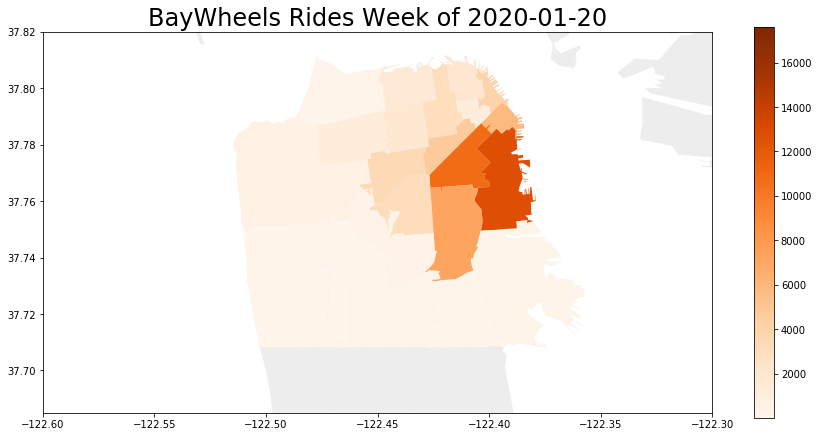

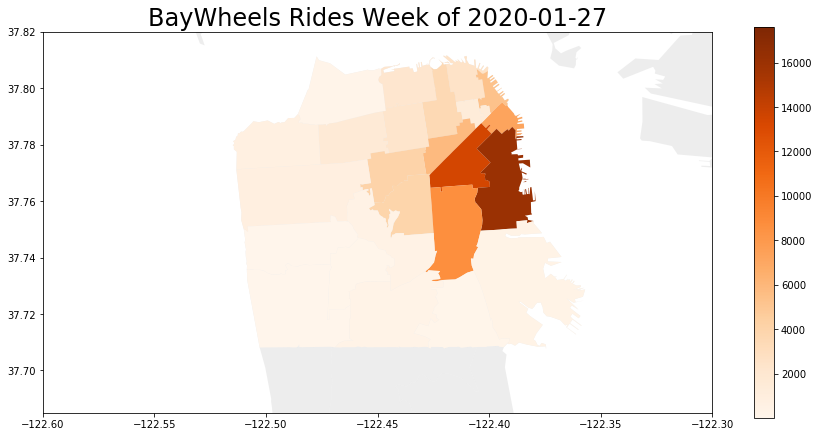

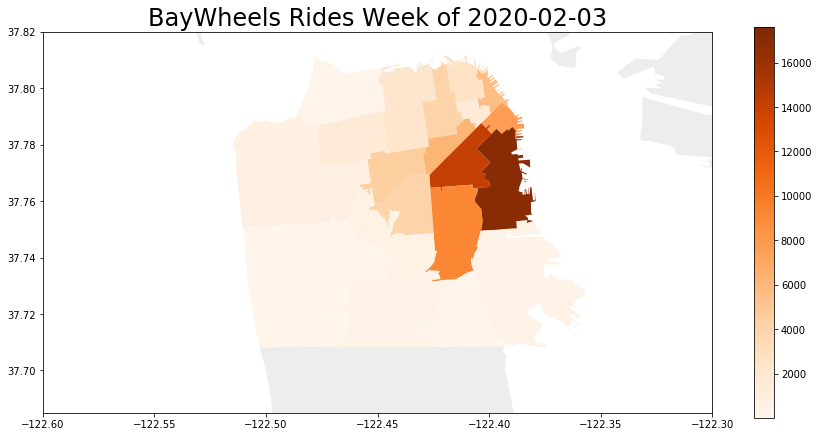

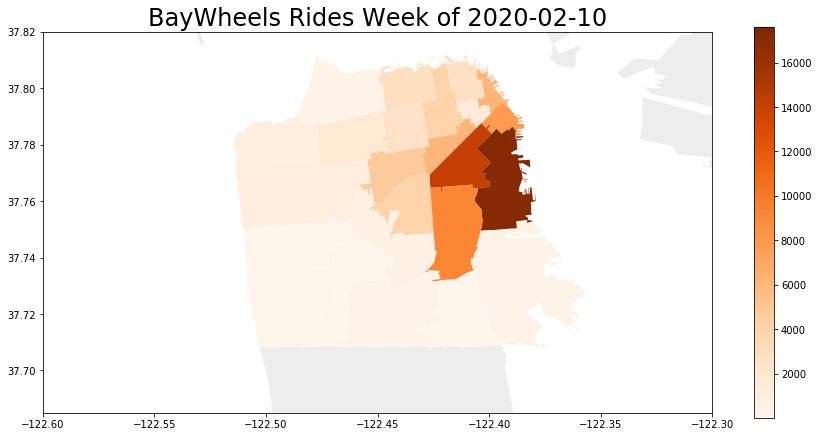

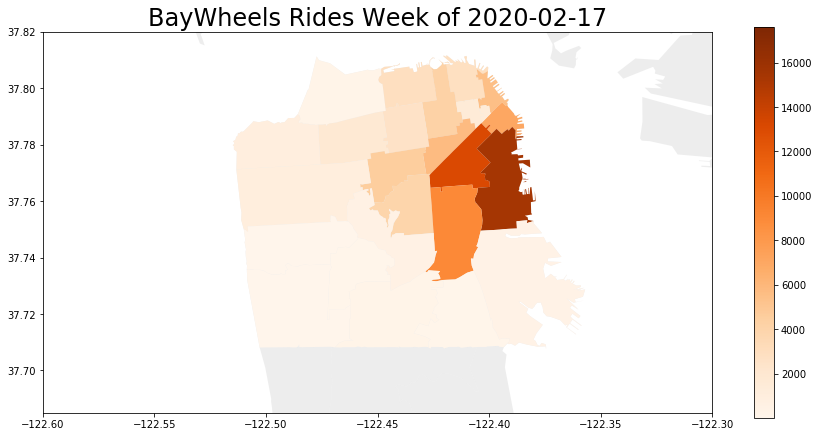

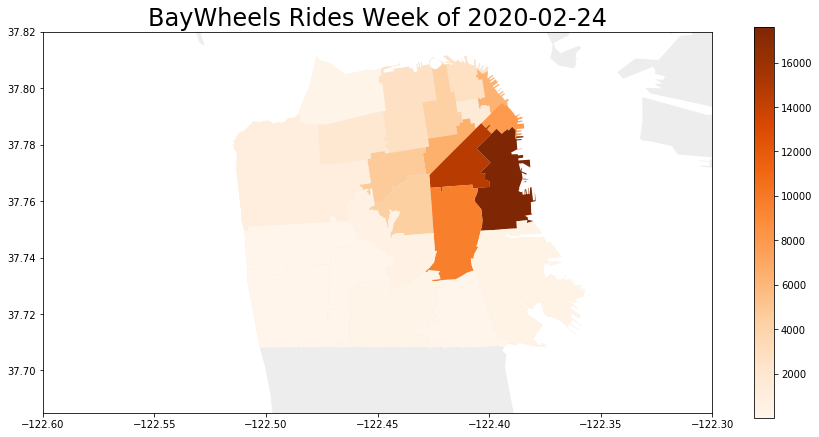

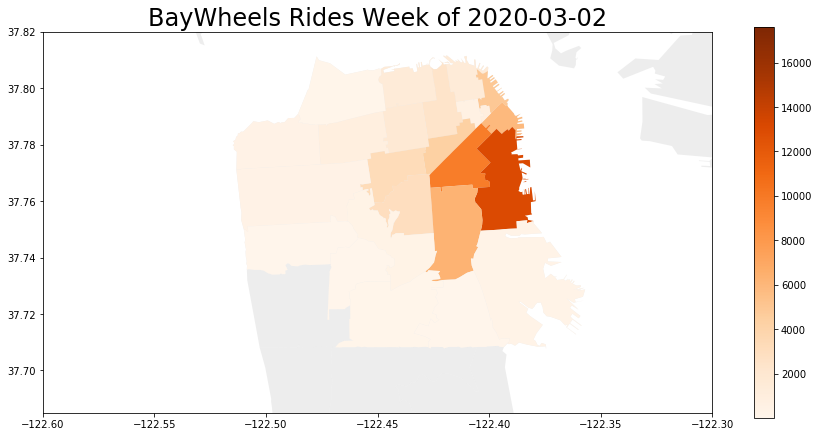

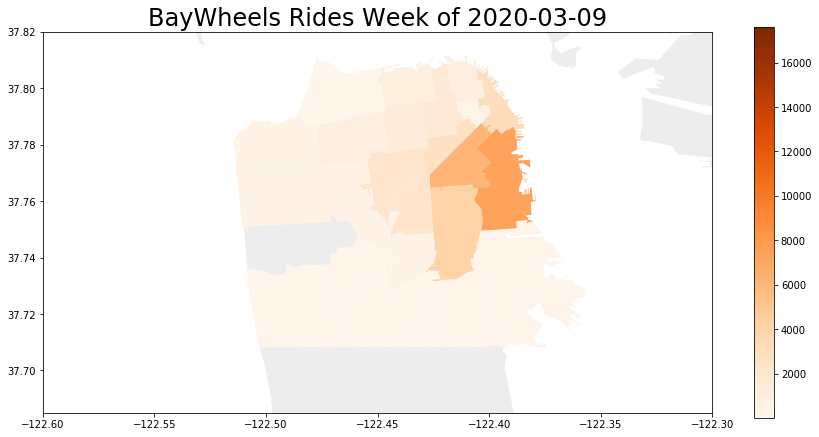

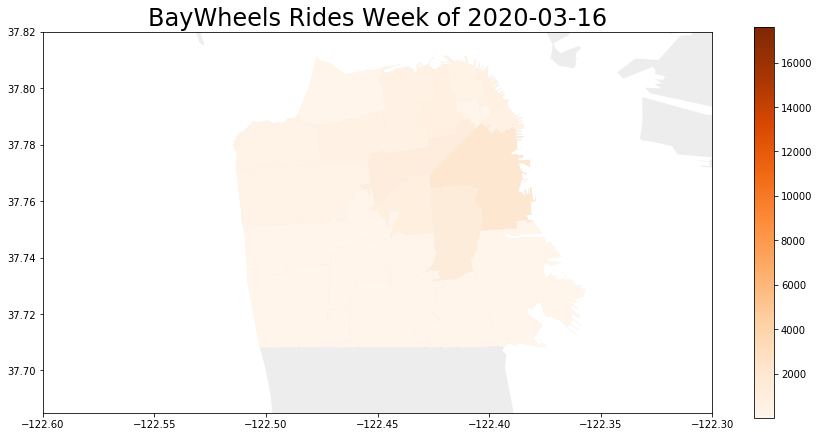

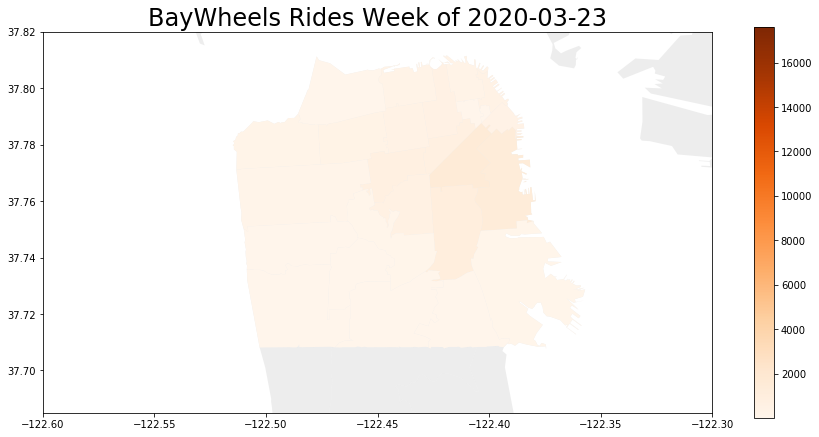

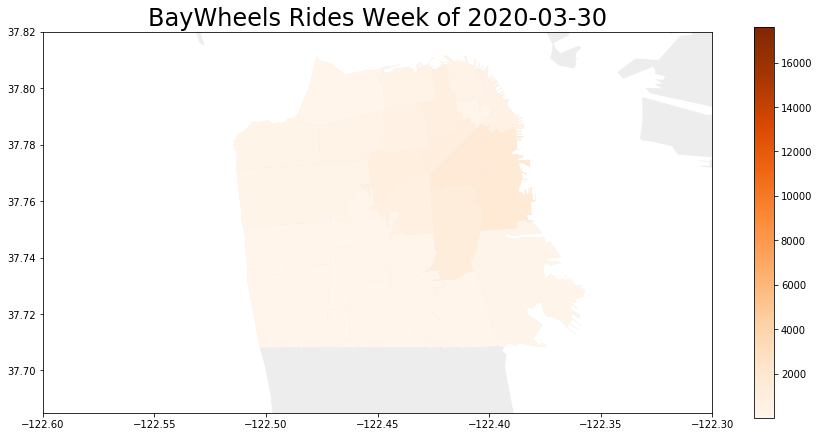

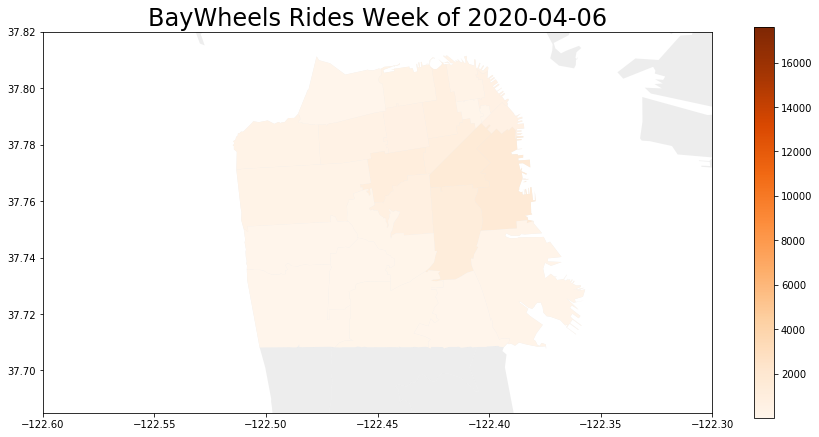

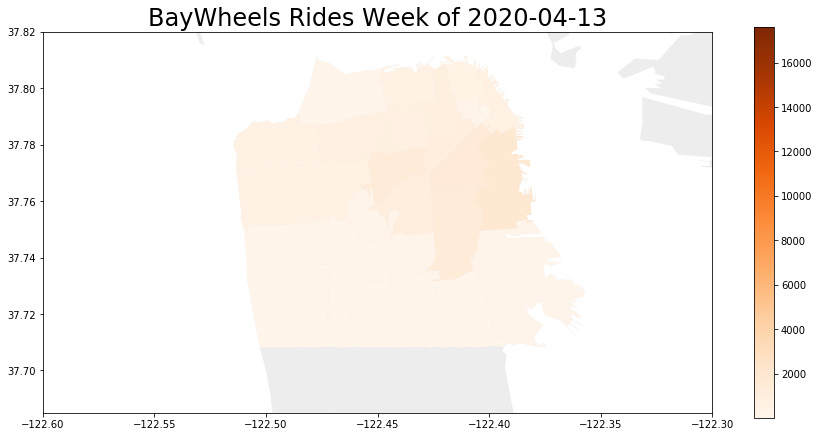

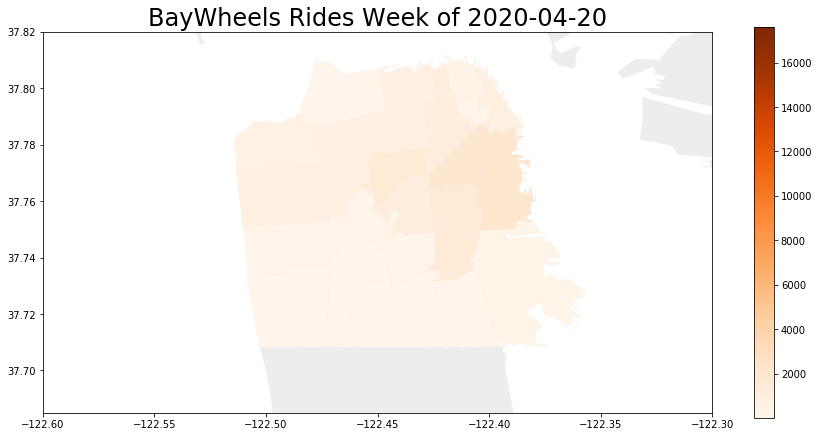

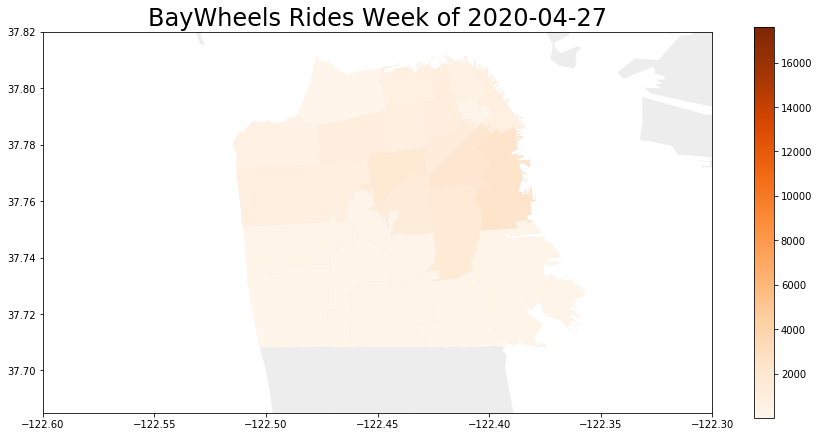

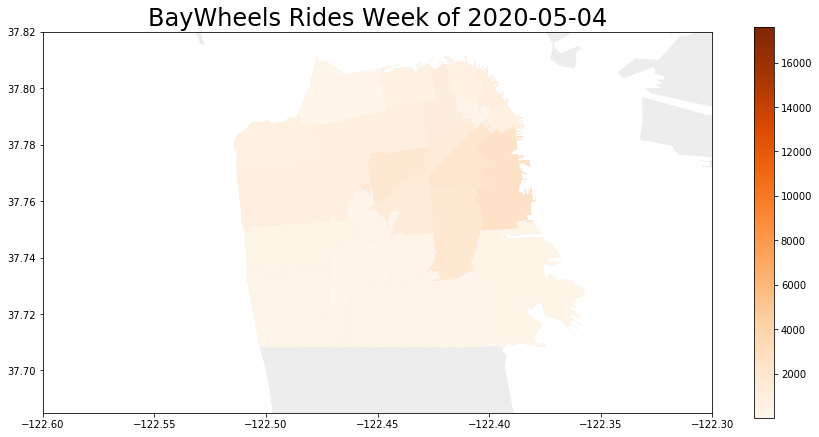

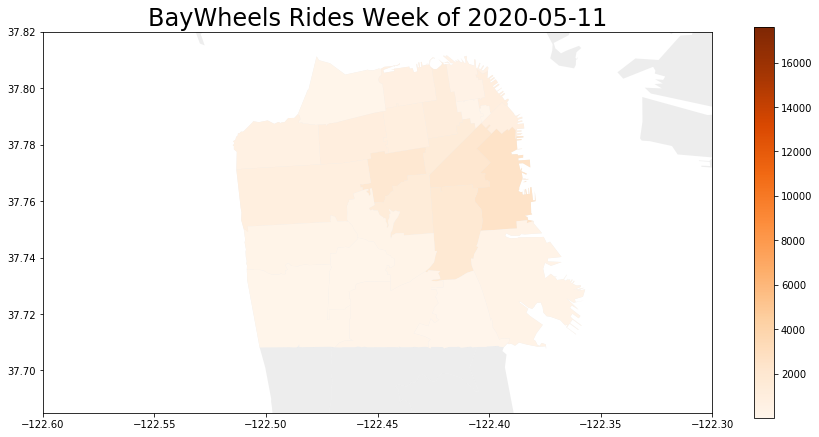

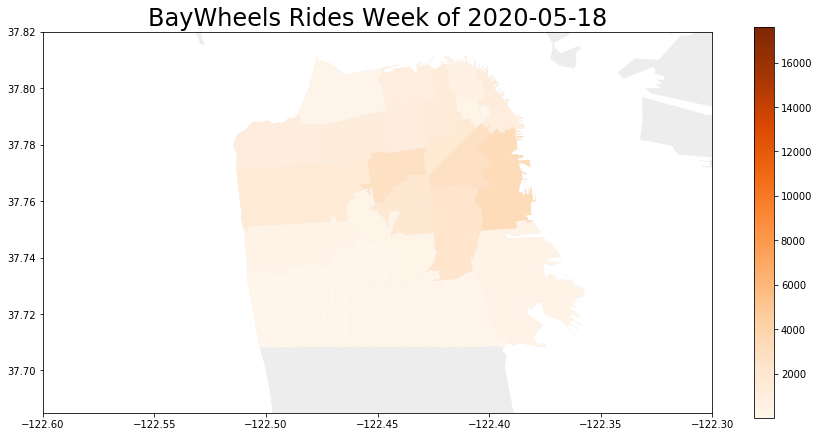

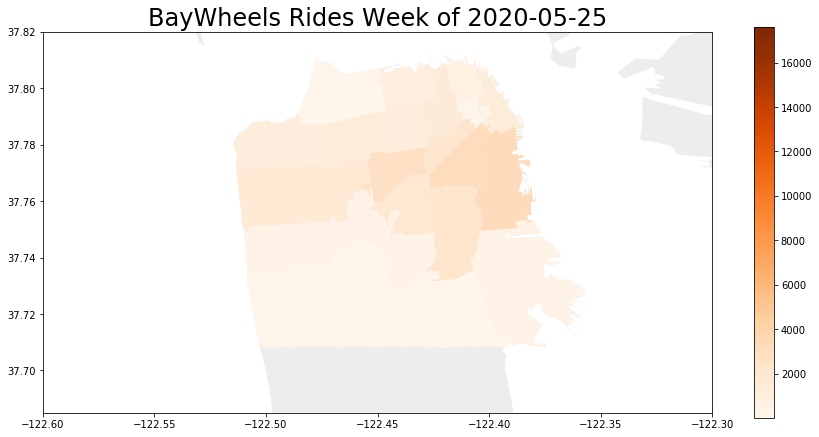

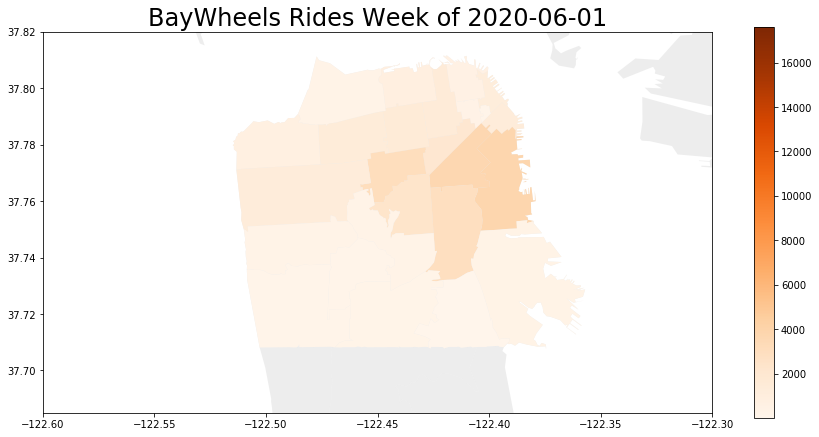

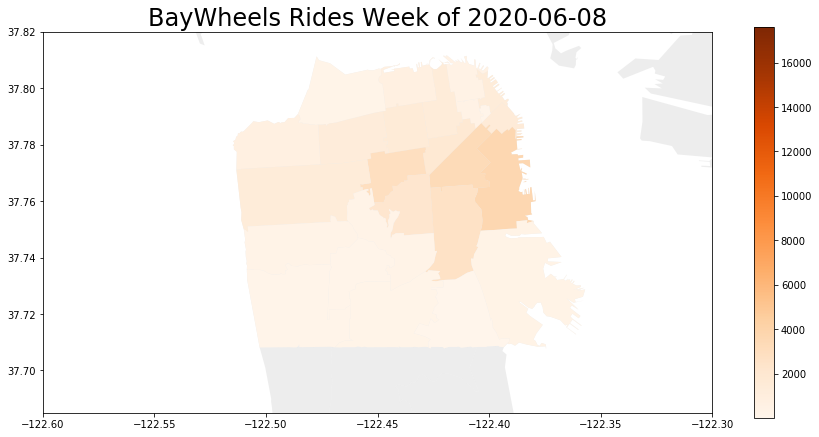

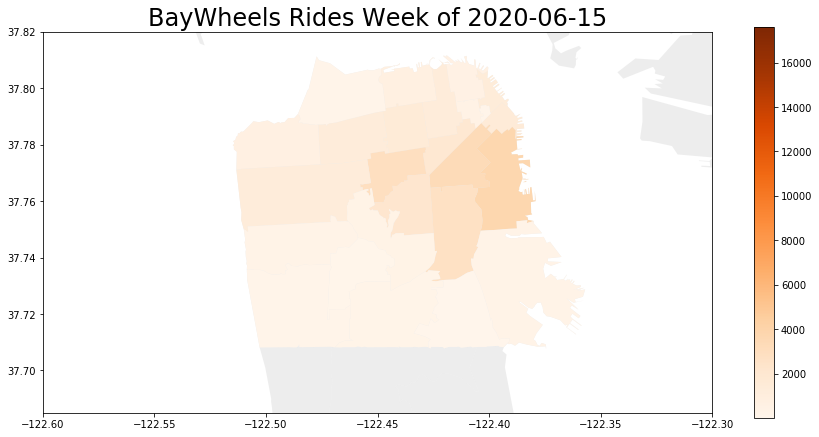

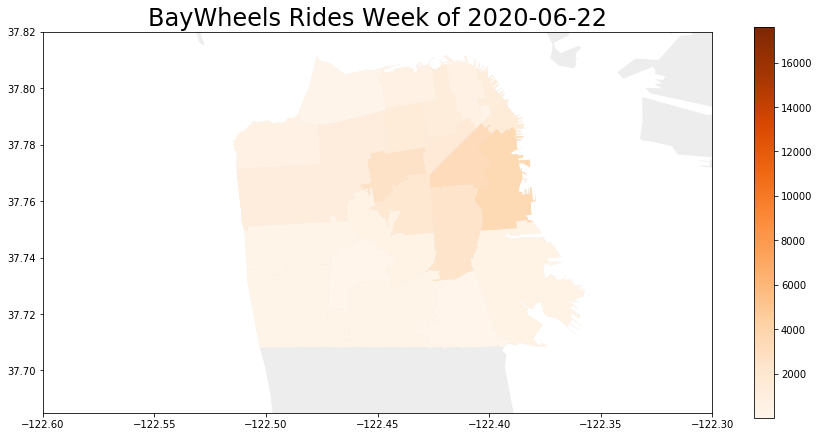

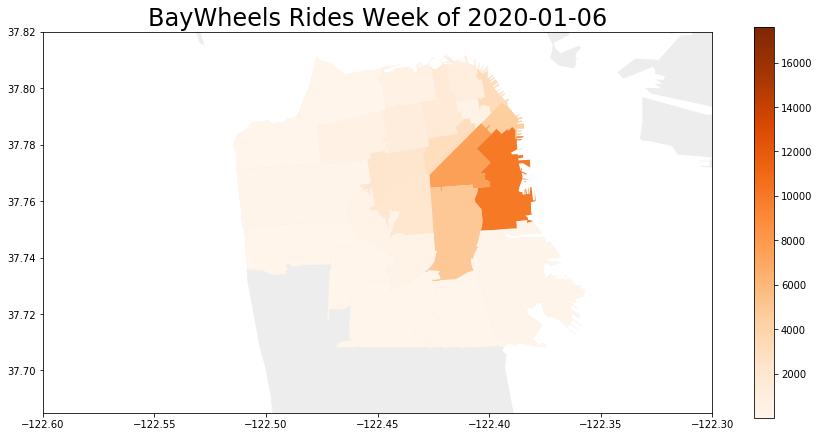

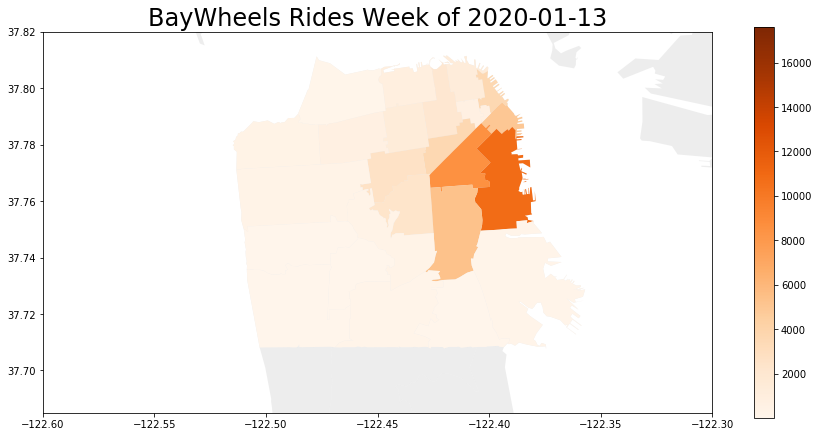

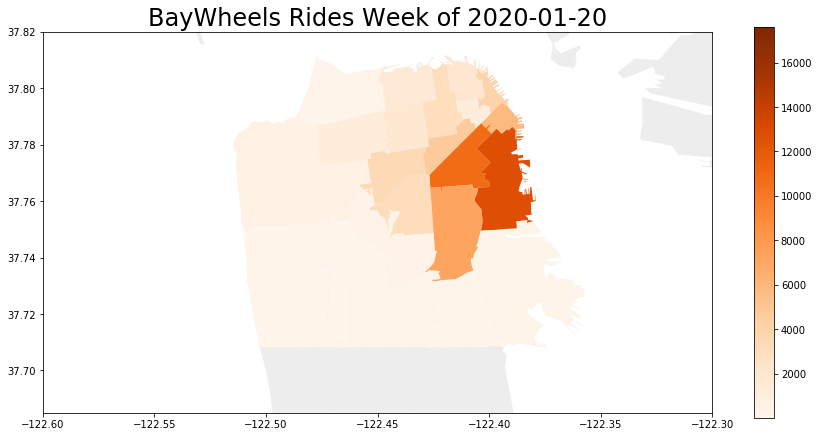

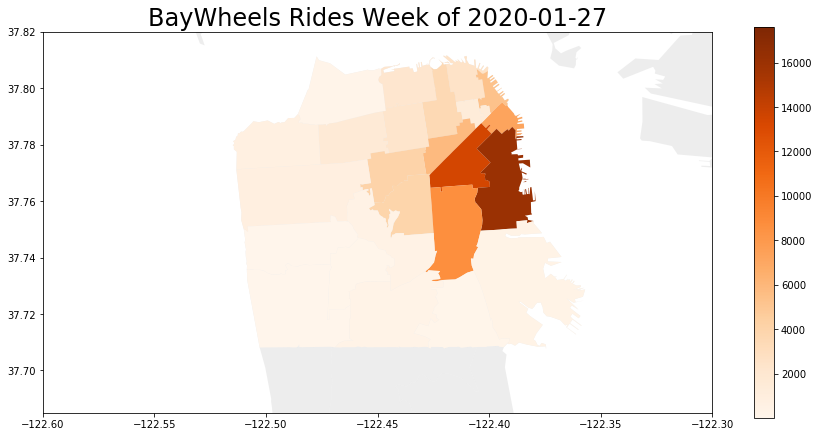

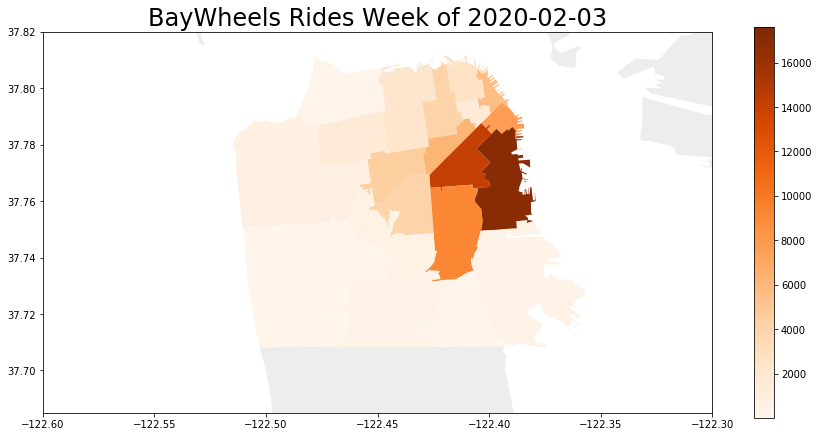

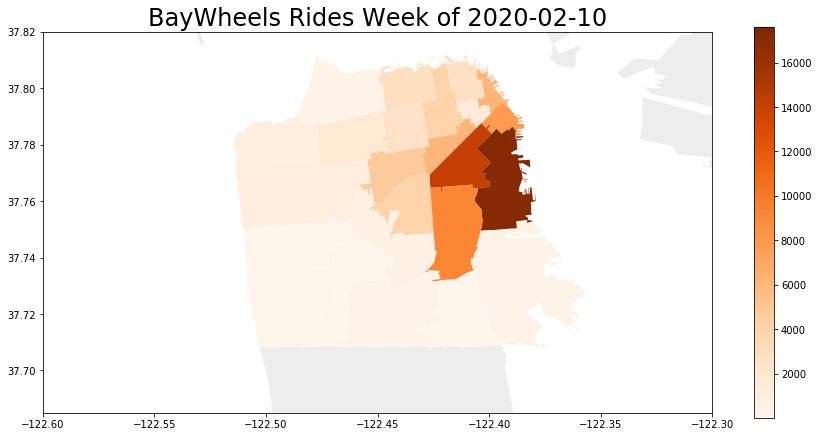

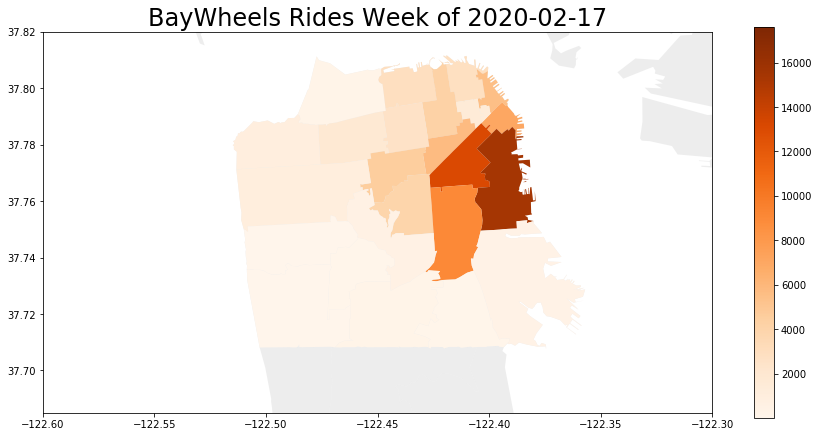

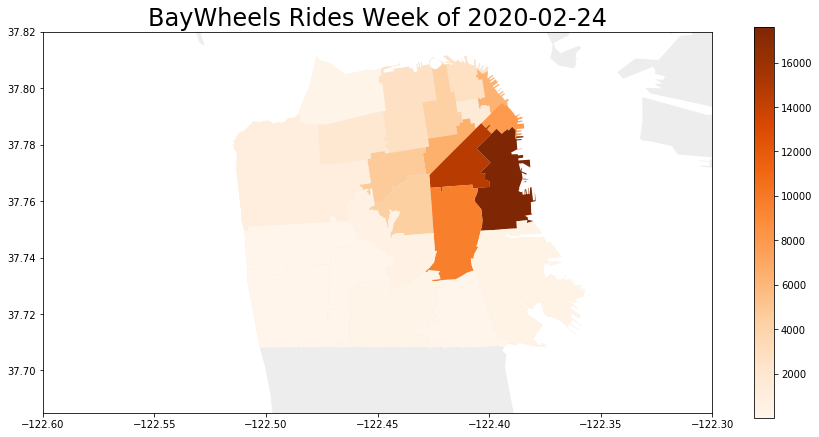

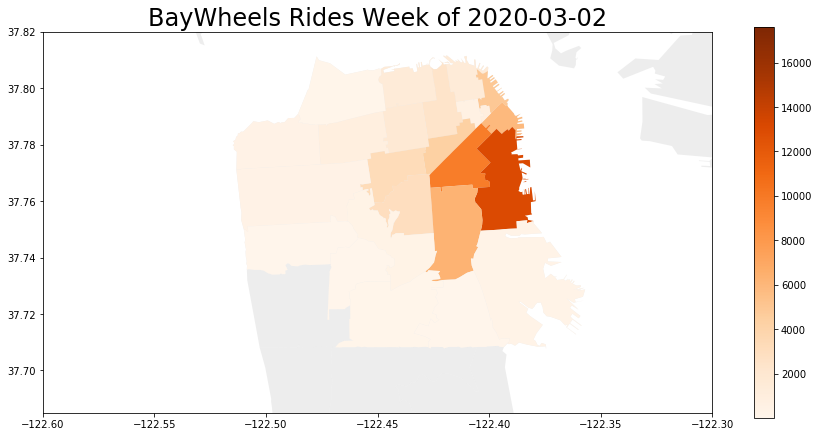

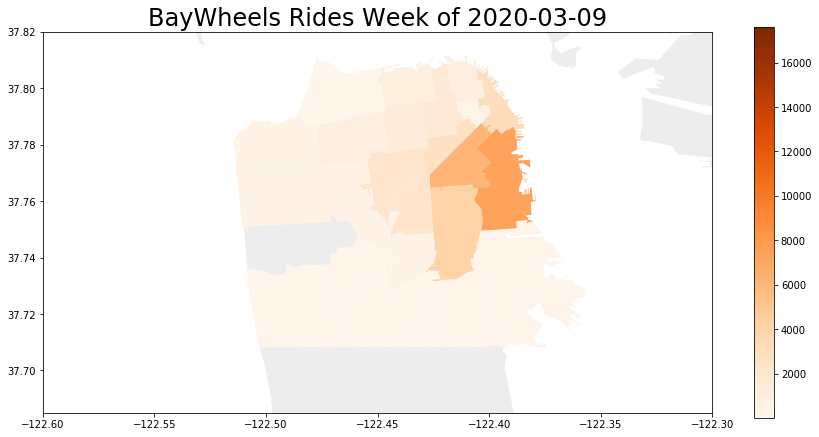

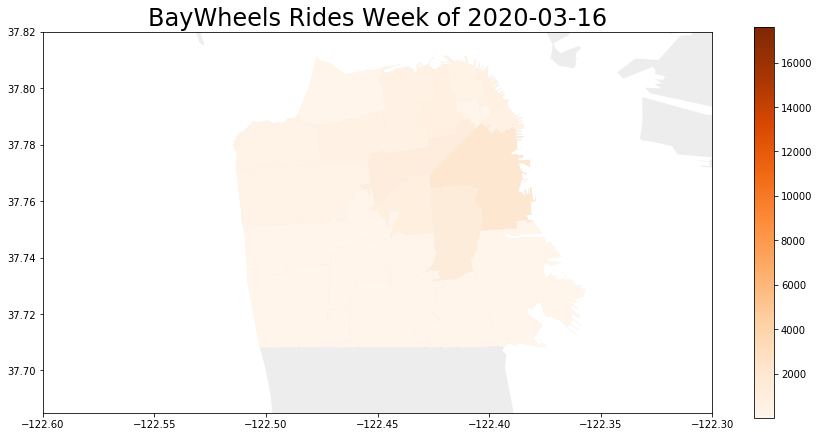

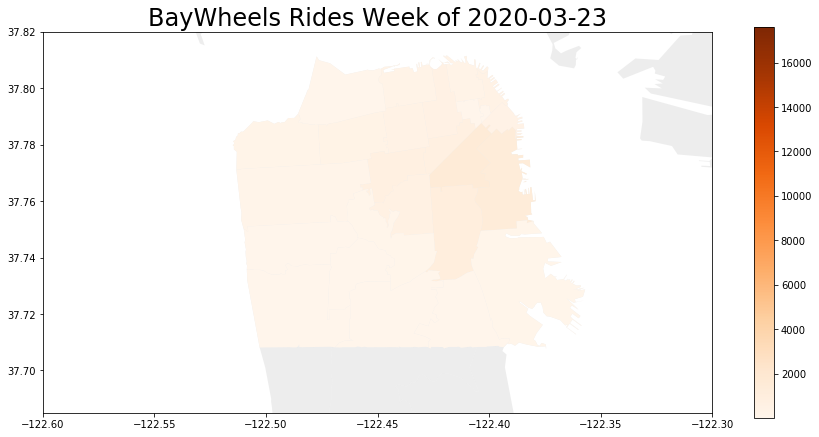

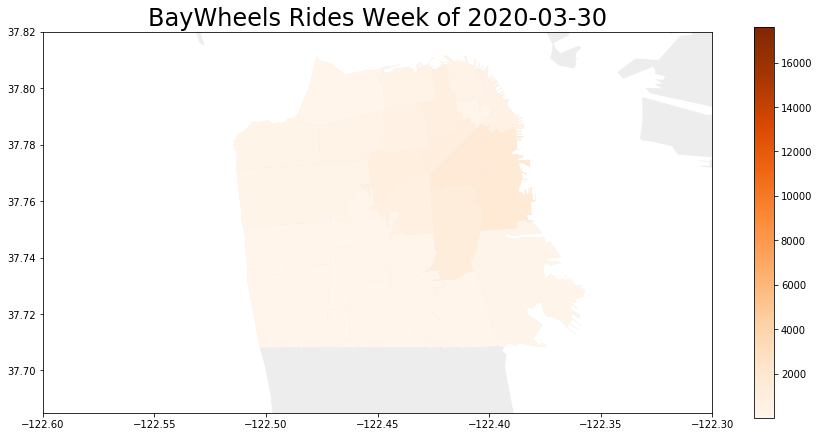

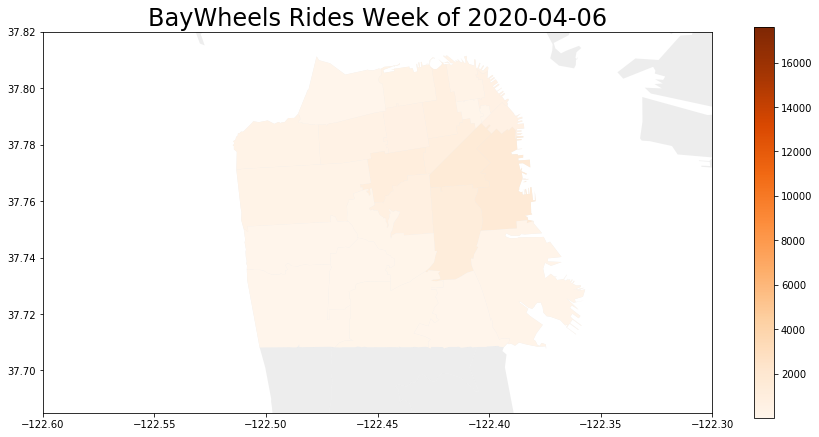

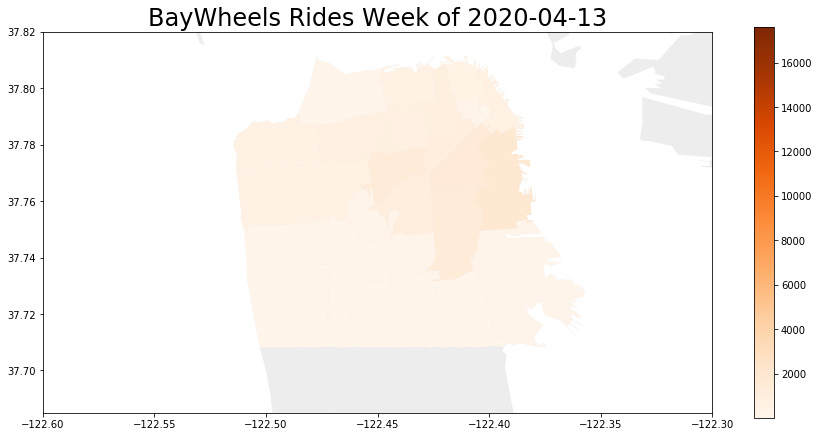

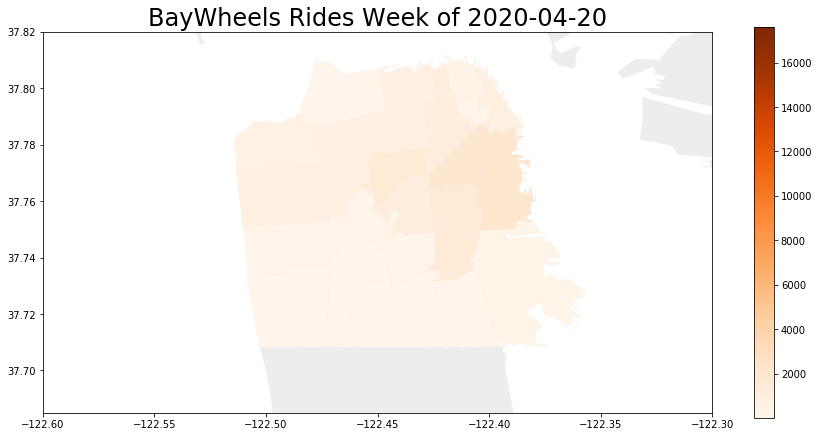

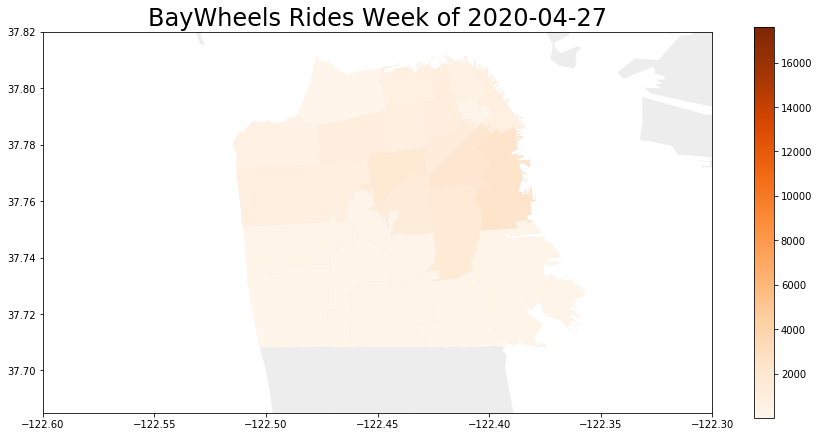

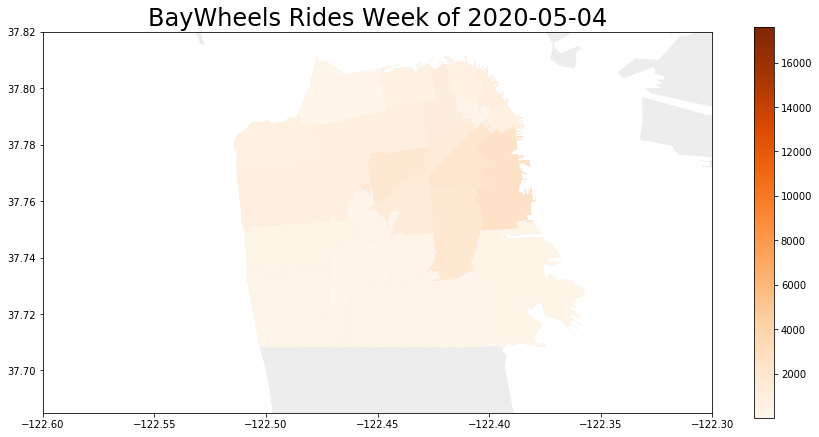

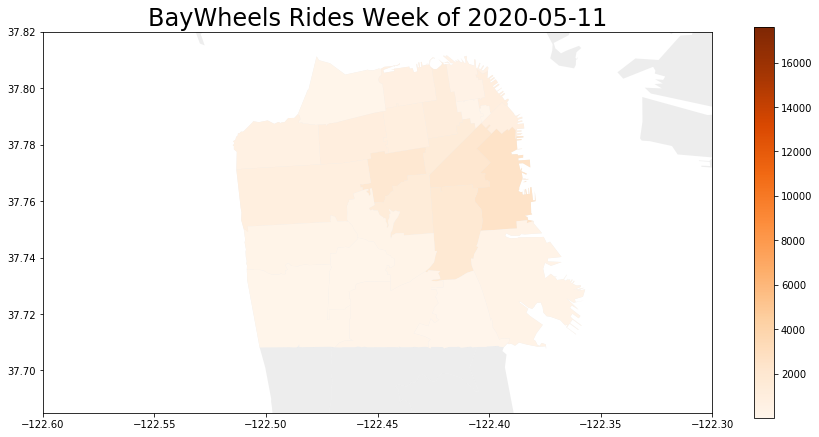

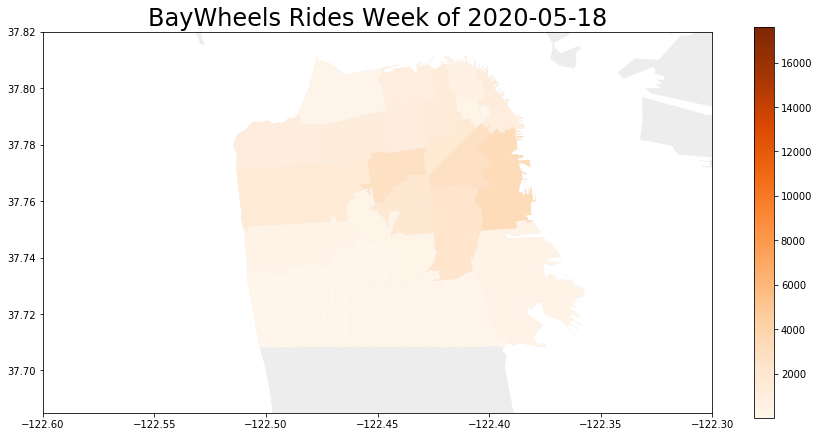

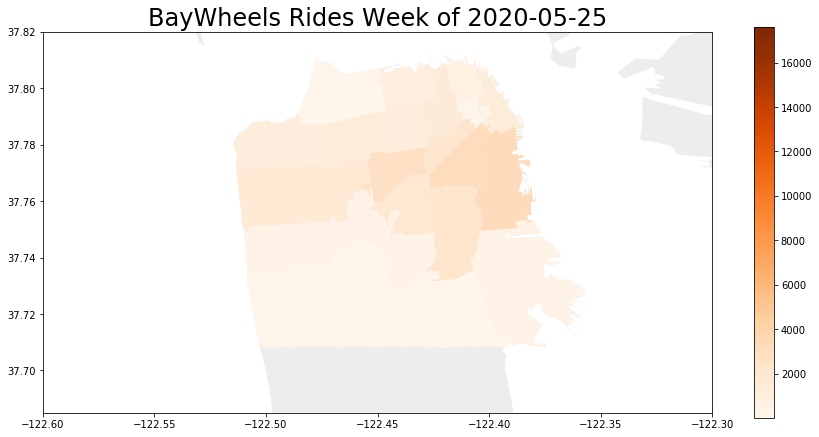

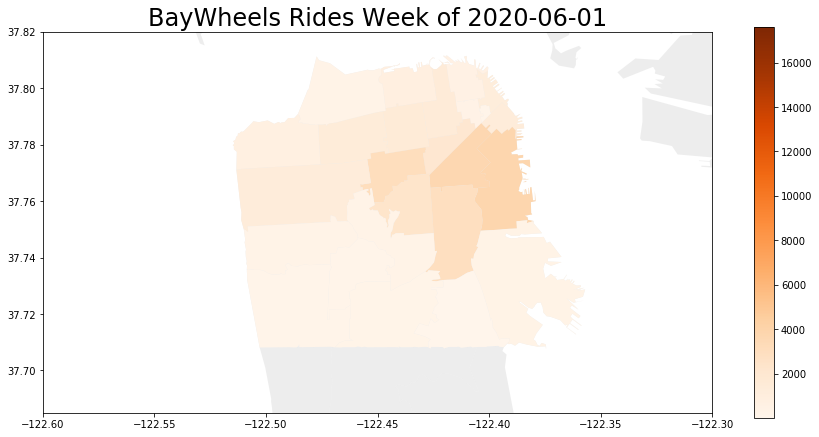

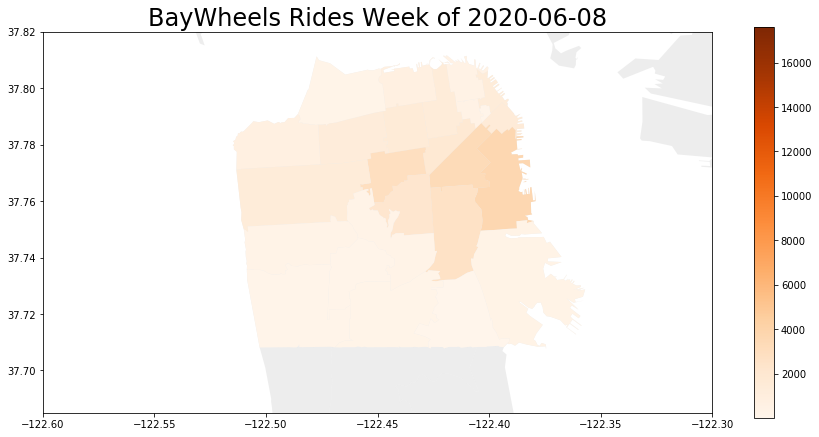

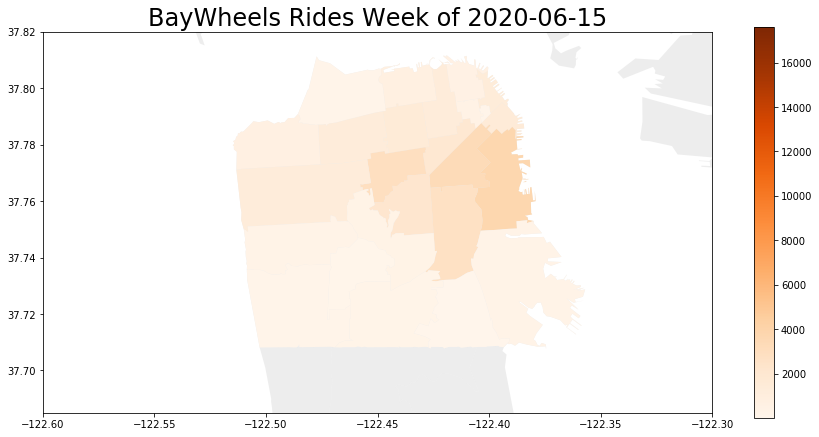

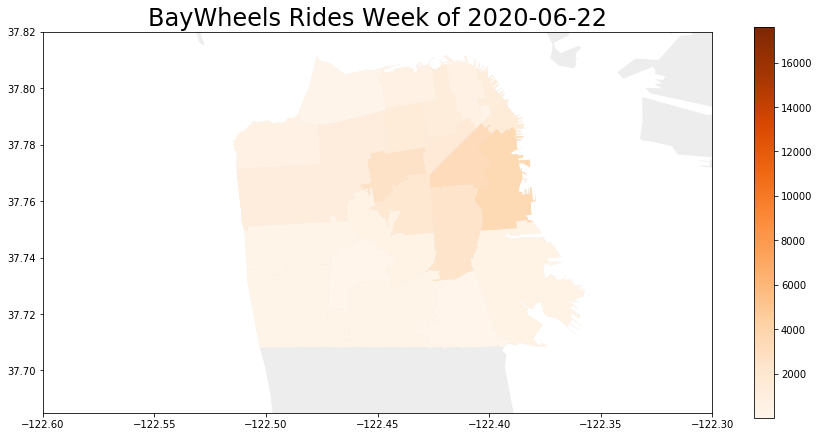

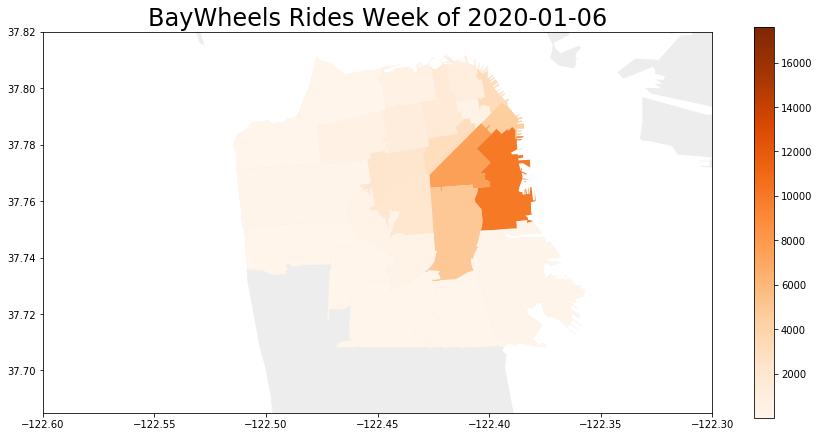

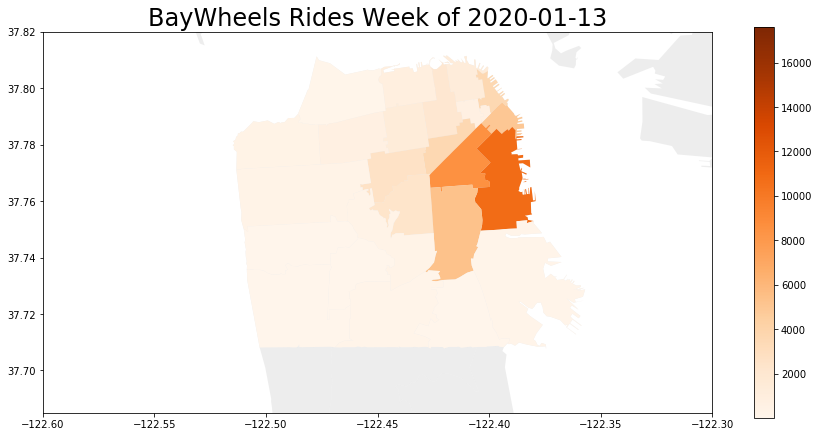

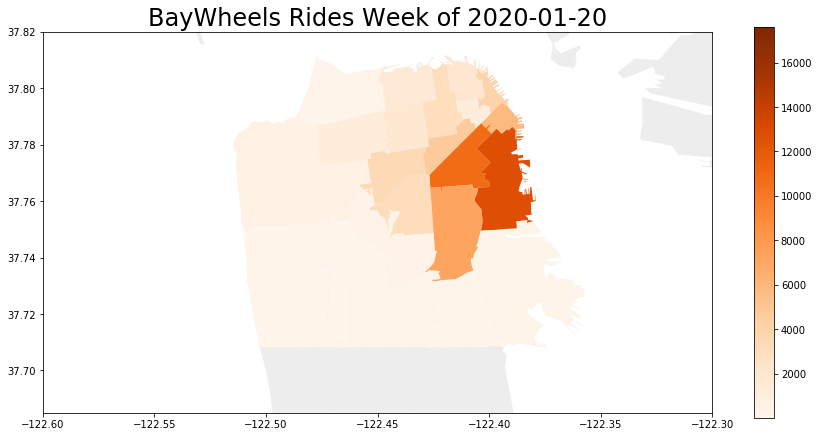

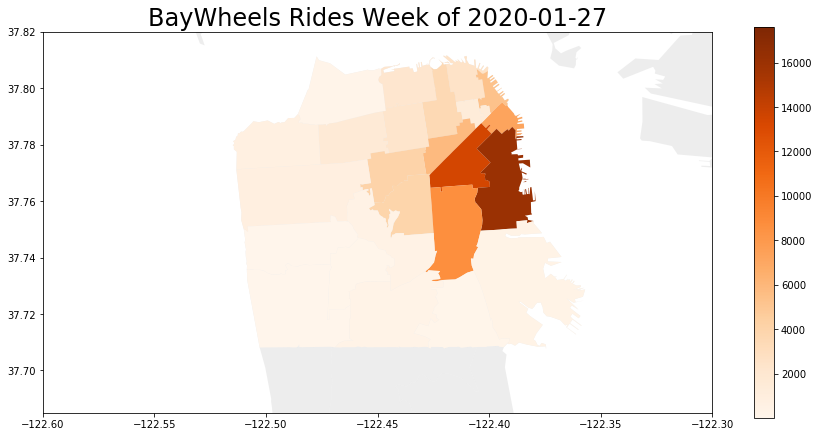

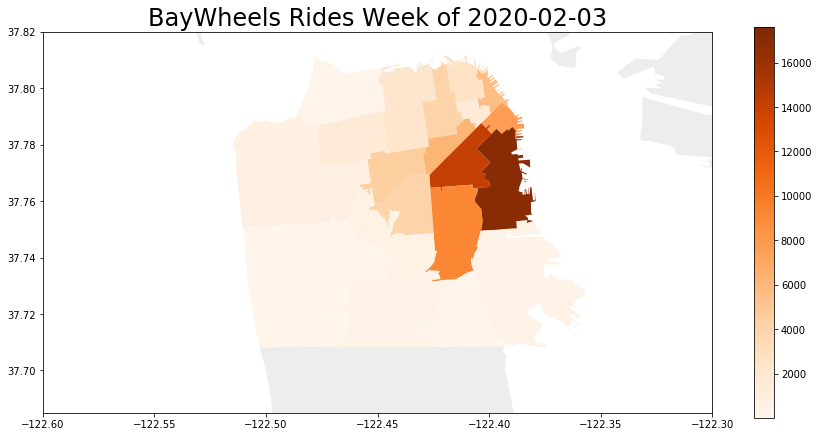

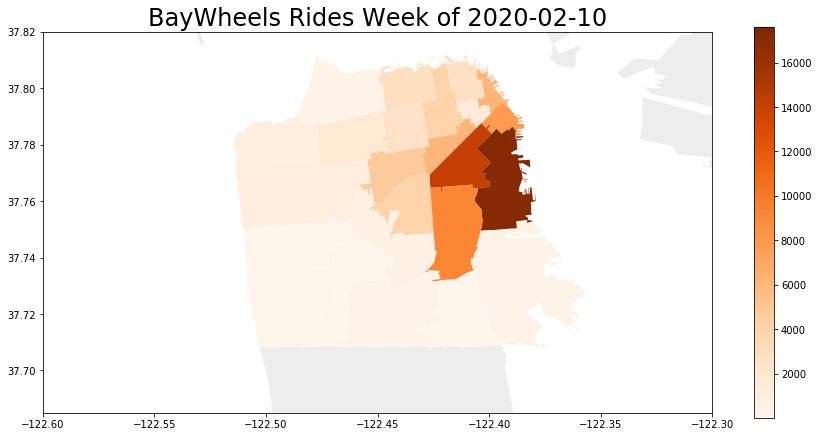

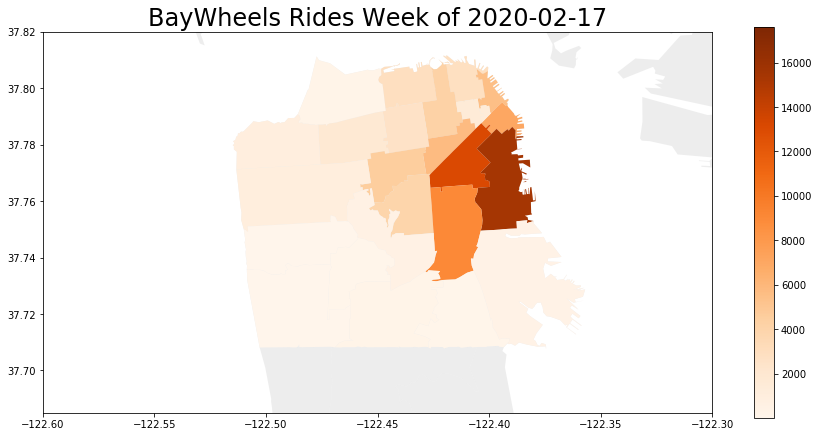

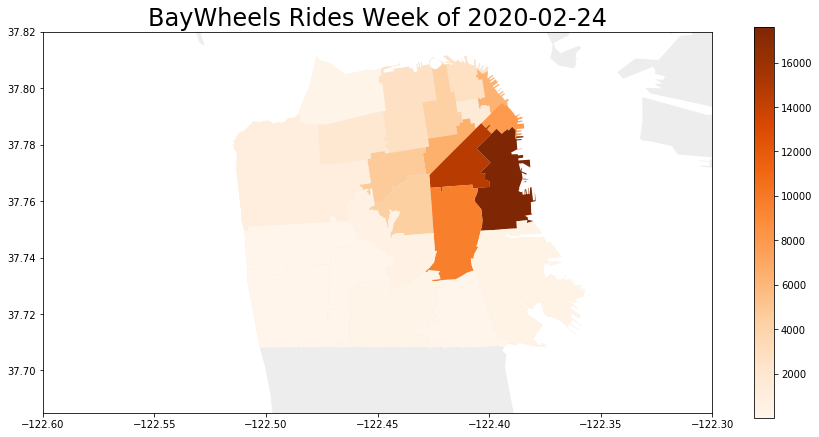

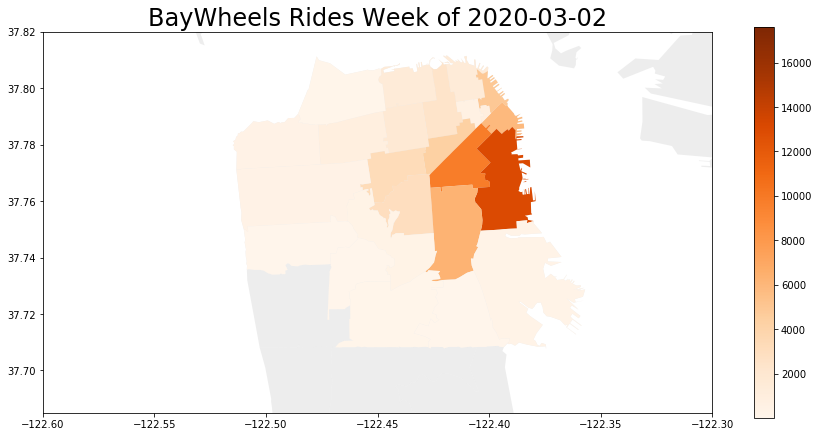

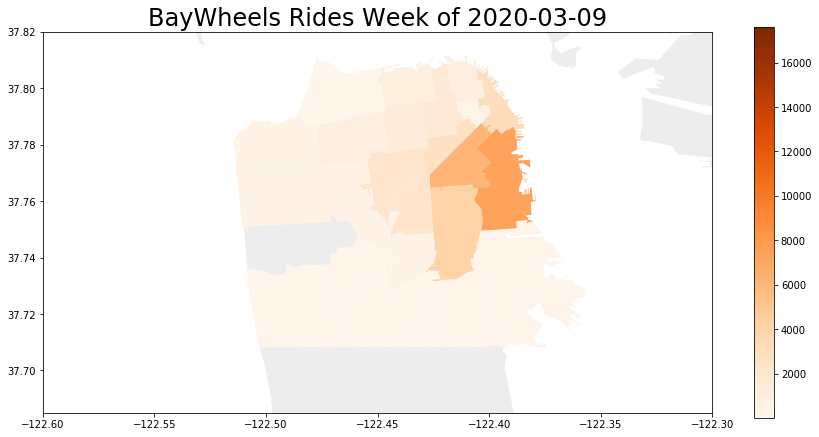

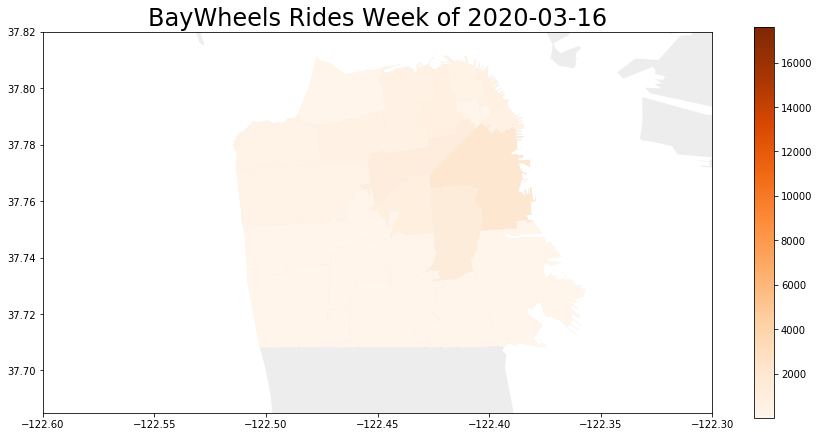

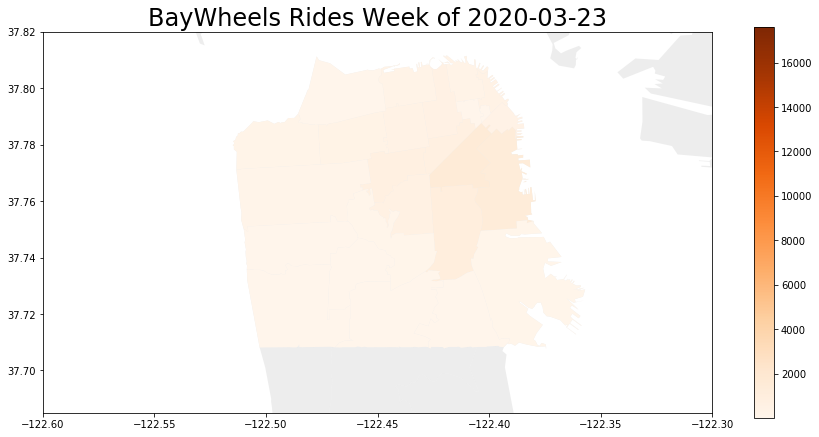

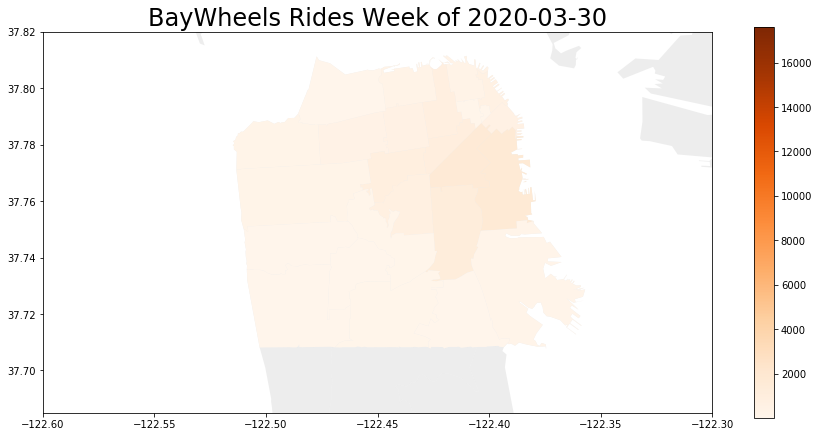

In [252]:
## Finally calling the function. Can replace x with test data for debugging

x= geo_df_with_counts 
print_map(x)

In [ ]:
## Final GIF

convert -delay 75 *.png baywheels-project2.gif

## Sources

_This information, particularly the tutorials and guides on `Medium`, were instrumental in this project_

#### Medium Articles
1. Importing CSVs: https://medium.com/@kadek/elegantly-reading-multiple-csvs-into-pandas-e1a76843b688
2. Time lapse display: https://medium.com/@tyreus/visualizing-the-spread-of-the-2019-coronavirus-with-python-7e63230f9505
3. GeoPandas Plotting:      https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

#### Primary Sources
4. Bike Data:      https://s3.amazonaws.com/baywheels-data/index.html
5. Shape Files:    https://geodata.lib.berkeley.edu/?bbox=-127.749023+29.036961+-112.412109+45.675482&f%5Bdc_format_s%5D%5B%5D=Shapefile&f%5Bdct_spatial_sm%5D%5B%5D=San+Francisco+Bay+Area+%28Calif.%29&per_page=10

#### Formal Documentation
6. Pandas:         https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
7. GeoPanda Documentation: https://geopandas.org/reference.html
8. Matplotlib Colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

#### Historical Context
8. Bay Wheels Feb Price Increase: https://mashable.com/article/lyft-bay-wheels-ebike-price-increase/
9. COVID Timeline in Bay Area: https://abc7news.com/timeline-of-coronavirus-us-coronvirus-bay-area-sf/6047519/